# BERTの訓練
ML（ミニバッチ単位で学習属性シャッフル）

In [1]:
import torch
import torchtext
import torch.optim as optim
from torch import nn
from utils.bert_mecab_snk import BertTokenizer, load_vocab, get_config, BertModel, set_learned_params
import BertForSNK as BFS
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from IPython.display import display, HTML
from statistics import mean
import AttentionVisualizer
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import numpy as np
import pandas as pd

from tqdm import tqdm
import collections
from collections import Counter, defaultdict
import itertools
import random
import sys
import time
import os
import pickle
import json
import csv
import math
import re
import copy
import shutil
from statistics import mean, median
from functools import partial
import fcntl
sys.path.append("../")
import config

from torchviz import make_dot
from IPython.display import display
import warnings
warnings.simplefilter('ignore')

"""
設定
"""

# モデル番号, 手動で設定する場合はここで
index_model = None

target_docGenre_list = ["twitter"] # ["minutes", "twitter"]
target_city_list = ["yokohama", "osaka"] # ["yokohama", "osaka"]
target_topic_list = ["IR", "待機児童"] # ["待機児童", "IR", "ワクチン"]
target_attr_list = ["立場", "適合性"] # 複数属性を指定するとマルチタスクラーニング
# 0番目がメインタスク. 各ラベルの損失重みの計算や正解・誤りデータの表示はメインタスクを対象とする

# 交差検証するか
mode_crossval = [None, 1, 2, 3, 4, 5][1]

# 乱数シード値
rd_seed = [1122, 1212, 2211][0]

# 未アノテーションデータをテストデータとして用いるか
flag_use_unknown = False

# 賛否両論を消すか
flag_rem_label3 = True

# 各属性の損失の重み
weight_loss = [1, 1]

mode_CLS = ["stc", "doc", "stc_and_doc"][2] # 何を分類するか. 文, 文書, 文&文書
mode_loss_two_type = ["macro", "micro"][1] # 文，文書同時学習を使う際の, lossの計算方法

# 文書埋め込みの抽出方法
mode_docVec = ["CLS", "max", "min", "ave",
               "ave_stc", "max_stc", "w_stc", "w_stc-2", "auto"][-3]
# 文埋め込みの抽出方法
mode_stcVec = ["CLS", "max", "min", "ave"][-1]

mode_target_use = {0: "", 1: "target_encode-ave", 2: "target_encode-max", 3: "target_encode-cat", 
                   4: "target_attn-in-12", 5: "target_attn-in-1", 
                   6: "target_attn-in-1-before", 7: "target_attn-in-1-before-LSTM",  
                   8: "target_attn-out", 9: "target_attn-out-CLS", 
                   10: "target_attn-out-drop-norm", 11: "target_attn-out-norm",
                   12: "target_attn-out-CLS-drop-norm", 
                   13: "target_attn-out-LSTM", 14: "target_attn-out-LSTM-norm"}[8]

max_length_target = 32 # ターゲット文のトークン数
repeat_target_emb = False # ターゲット文を埋め込んで複製するか(True)，複製して埋め込むか(False)

flag_multi_TA = True # MLT時にターゲットアテンションを属性別に用意するか
mode_BP_ML = ["join", "each", "shuf"][-1] # ML時の逆伝播の方法 [ロス結合, 個別に逆伝播. ミニバッチ単位で属性をシャッフル]

hyper_params = {
            "doc_genre": sorted(target_docGenre_list),
            "city": sorted(target_city_list),
            "topic": sorted(target_topic_list),
            "attr": target_attr_list,
            "mode_CLS": mode_CLS,
            "mode_docVec": mode_docVec,
            "mode_stcVec": mode_stcVec,
            "mode_target_use": mode_target_use,
            "flag_multi_TA": flag_multi_TA,
            "mode_BP_ML": mode_BP_ML,
            "repeat_target_emb": repeat_target_emb,
            "lr": 5e-05,
            "f_layers": 12,
            "max_length": [64, 128, 256, 512][0],
            "max_length_target": max_length_target,
            "truncate_first": False,
            "batch_size": [8, 16][1],
            "num_epochs": [5, 10][0],
            "attn_mask": True,
            "weight_class": [None, True, [0.5, 2, 2, 2]][0],
            "weight_loss": weight_loss,
            "under_sampling_doc": None,
            "under_sampling_stc": [0.5, None],
            "flag_share": False,
            "mode_loss_two_type": mode_loss_two_type,
            "flag_use_unknown": flag_use_unknown,
            "mode_crossval": mode_crossval,
            "flag_rem_label3": flag_rem_label3,
            "rd_seed": rd_seed
        }

# Noneなら, 今回の学習結果の正解率が, 過去のものより良い場合モデルを保存
# Falseなら保存しない
# Trueなら問答無用で保存
flag_save_model = False

# 履歴を保存するか
flag_save_history = True

# .ipynbをHTMLに出力するか
flag_save_html = False

# Attentionを可視化する
flag_visualize_attention = True

#################################################################

learning_rate = hyper_params["lr"] # 学習率
max_length = hyper_params["max_length"] # 入力する文章の最大単語数
flag_truncate_first = hyper_params["truncate_first"] # 入力テキストがmax_lengthより長い場合, 前方を捨てるか
batch_size = hyper_params["batch_size"] # #BERTでは16、32あたりを使用する
num_epochs = hyper_params["num_epochs"] # エポック数
weight_class = hyper_params["weight_class"] # 損失計算でクラスの重みを考慮するか
flag_attn_mask = hyper_params["attn_mask"] # Attentionにマスクをするか
ratio_under_sampling_doc = hyper_params["under_sampling_doc"] # ダウンサンプリングするか. float: 何割削除するか. None: ダウンサンプリングしない
ratio_under_sampling_stc = hyper_params["under_sampling_stc"] # ダウンサンプリングするか. float: 何割削除するか. None: ダウンサンプリングしない
flag_share = hyper_params["flag_share"] # sscを行う場合, 分類器を文書全体の分類器と共有するか

flag_two_level = mode_CLS == "stc_and_doc"

param_for_2type_list = ["flag_share", "mode_loss_two_type", "under_sampling_stc"]
param_for_stc_and_doc = ["mode_stcVec"]
param_for_target = ["max_length_target", "repeat_target_emb", "flag_multi_TA"]
mode_docVec_require_2type_set = {"ave_stc", "max_stc", "w_stc", "w_stc-2", "auto"}
param_for_MTL_set = {"flag_multi_TA", "mode_BP_ML"}
flag_w_stc = "w_stc" in mode_docVec

# 各ラベルの表示名
# 順番をラベルの順番と対応させること
# 例 0: 中立, 1: 賛成, 2: 反対 なら ["中立", "賛成", "反対"]
# {attr: [label1, label2, ...], ...}
labelStr_dict = {attr: config.Config.labelStr_dict[attr] for attr in target_attr_list}

city_list = config.Config.city_list
usage_list = config.Config.usage_list

#ファインチューニングする層の数を選ぶ（12まで）
# 6なら, 最奥(12層目)から6層目までをファインチューニングする
# 0はFTなし
f_layers = hyper_params["f_layers"]

if not(flag_two_level):
    for param in param_for_2type_list:
        del hyper_params[param]

if mode_CLS != "stc_and_doc":
    for param in param_for_stc_and_doc:
        del hyper_params[param]
    mode_stcVec = None
    
if not mode_target_use:
    for param in param_for_target:
        del hyper_params[param]
    flag_multi_TA = False
    
if len(target_attr_list) == 1:
    for param in param_for_MTL_set:
        if param in hyper_params:
            del hyper_params[param]
    flag_multi_TA = False

# torch.datasetの一行に含まれる属性の数
if len(target_attr_list) >= 2 and mode_BP_ML == "shuf":
    num_attr_one_record = 1
else:
    num_attr_one_record = len(target_attr_list)
    
if not(flag_two_level) and mode_docVec in mode_docVec_require_2type_set:
    raise Exception("文or文書 単体の学習なのに, 文の平均, 最大値etcを指定")

if flag_two_level and mode_docVec not in mode_docVec_require_2type_set:
    raise Exception("文&文書 の学習なのに, 文の平均, 最大値etcを指定していない")

num_target_attn_layer = None
if re.search(r"\d+", mode_target_use):
    num_target_attn_layer = int(mode_target_use.split("-")[2])
    if num_target_attn_layer < 1:
        raise Exception("BERTと内部に組み込む課題文アテンションの層の数が0")

if flag_use_unknown and mode_crossval:
    raise Exception("未知データの予測を指定しているのに，交差検証を指定")

if "立場" not in target_attr_list:
    flag_rem_label3 = False
    del hyper_params["flag_rem_label3"]
elif flag_rem_label3 and len(labelStr_dict["立場"]) > 3:
    del labelStr_dict["立場"][3]
    
# マルチタスクラーニングをするか
flag_multitask = len(target_attr_list) > 1
main_attr = target_attr_list[0]

if flag_multitask and mode_docVec == "auto":
    raise Exception("マルチタスクラーニングでは非対応")
if len(target_attr_list) != len(weight_loss):
    raise Exception("対象属性の数と損失の重みの数が違う")

if flag_multitask:
    if mode_BP_ML == "shuf" and any(v is not None and (type(v) is not list or len(v) != len(target_attr_list)) for v in [ratio_under_sampling_doc, ratio_under_sampling_stc]):
        raise Exception("mode_BP_ML=shuf なのに，ダウンサンプリング率がリストでない or サイズがおかしい")
    elif mode_BP_ML != "shuf" and any(type(v) is list for v in [ratio_under_sampling_doc, ratio_under_sampling_stc]):
        raise Exception("mode_BP_ML=shuf でないのに，ダウンサンプリング率がリスト")
else:
    if any(type(v) is list for v in [ratio_under_sampling_doc, ratio_under_sampling_stc]):
        raise Exception("シングルタスクなのに，ダウンサンプリング率がリスト")
    
#乱数のシードを設定
torch.manual_seed(rd_seed)
np.random.seed(rd_seed)
random.seed(rd_seed)

# 課題文アテンションの数
num_TA = len(labelStr_dict) if flag_multi_TA else 1

if not mode_crossval:
    path_dir_dataset = "../annotation/file_label"
else:
    path_dir_dataset = "../annotation/file_crossval"
path_dir_dataset_unknown = "../annotation/file_unknown"

path_dataset_base = "%s/%s/{dg}_{c}_{t}_{a}_%s_{u}.tsv" % (path_dir_dataset, mode_CLS, mode_CLS)
path_dataset_base_unknown = "%s/%s/{dg}_{c}_{t}_{a}_%s.tsv" % (path_dir_dataset_unknown, mode_CLS, mode_CLS)

topic_dict = config.Config.topic_dict
topic_list = list(topic_dict.keys())
topic_localID_dict = {}
for t, i in topic_dict.items():
    if t in target_topic_list:
        topic_localID_dict[i] = len(topic_localID_dict)

target_stc_dict = config.Config.target_stc_dict

path_vocab = "../vocab.txt"
path_config = "" #bertのconfigのパス
path_weight = "" #学習済みbertのパス

path_dir_model = "model"
path_dir_graph_epoch = "graph/epoch"
path_dir_graph_vec = "graph/vec"

path_dir_html = "html"
path_dir_pred_test = "pred/test"

str_sep_org = ["\ue000", "\ue001", "\ue002", "\ue003"][0]

path_history = "history.json"
path_dir_his_backup = "history_backup"
path_history_copy = "{}/history_{}.json".format(path_dir_his_backup, str(time.time())[-1])

# ディレクトリ作成
for path_file in [path_dir_model, path_dir_graph_epoch, path_dir_graph_vec, path_dir_html, path_dir_pred_test, path_dir_his_backup]:
    os.makedirs(path_file, exist_ok=True)

# 今回の学習の設定が, 履歴ファイルで既存か確認する
# 既存の場合そのインデックスを取得, ない場合新たなインデックスに割り当て
new_setting = ""

# 既存設定か確認
if index_model is None:
    # 履歴を読み込む. 履歴ファイルがない場合, 空の辞書を作成
    if os.path.isfile(path_history):
        with open(path_history, "r", encoding="utf-8") as f:
            fcntl.flock(f.fileno(), fcntl.LOCK_SH)
            index_result_dict = json.load(f)
            fcntl.flock(f.fileno(), fcntl.LOCK_UN)
    else:
        index_result_dict = {}
    
    # 存在チェックのために使う辞書(index_result_dictのキーと値を反転したもの)
    result_index_dict = {str(d["hyper_params"]): i for i, d in index_result_dict.items()}
    
    if str(hyper_params) in result_index_dict:
        index_model = result_index_dict[str(hyper_params)]
    else:
        if len(index_result_dict) == 0:
            index_model = 0
        else:
            index_model = max((int(i) for i in index_result_dict.keys())) + 1
        new_setting = "(new)"
else:
    if not os.path.isfile(path_history):
        raise Exception("初回は手動設定禁止")
    new_setting = "(manual)"
    
print("index_model:", index_model, new_setting)

path_model = "{}/BERT_{}.model".format(path_dir_model, index_model)
path_html = "{}/HTML_{}.html".format(path_dir_html, index_model)
path_file_pred_test_base = "%s/pred_test_%s_{a}.tsv" % (path_dir_pred_test, index_model)

# zip()に与えられたリストが全て同じサイズかチェックするラッパー関数
def myzip(*lst):
    s = len(lst[0])
    if any(len(v) != s for v in lst):
        raise Exception("イテレータのサイズが不一致 ({})".format([len(v) for v in lst]))
    return zip(*lst)

hyper_params

index_model: 0 


{'doc_genre': ['twitter'],
 'city': ['osaka', 'yokohama'],
 'topic': ['IR', '待機児童'],
 'attr': ['立場', '適合性'],
 'mode_CLS': 'stc_and_doc',
 'mode_docVec': 'w_stc',
 'mode_stcVec': 'ave',
 'mode_target_use': 'target_attn-out',
 'flag_multi_TA': True,
 'mode_BP_ML': 'shuf',
 'repeat_target_emb': False,
 'lr': 5e-05,
 'f_layers': 12,
 'max_length': 64,
 'max_length_target': 32,
 'truncate_first': False,
 'batch_size': 16,
 'num_epochs': 5,
 'attn_mask': True,
 'weight_class': None,
 'weight_loss': [1, 1],
 'under_sampling_doc': None,
 'under_sampling_stc': [0.5, None],
 'flag_share': False,
 'mode_loss_two_type': 'micro',
 'flag_use_unknown': False,
 'mode_crossval': 1,
 'flag_rem_label3': True,
 'rd_seed': 1122}

In [2]:
"""
データローダーの作成
"""

print("=== main attr: {} ===\n".format(main_attr))

#単語分割用のTokenizerを用意
tokenizer_bert = BertTokenizer(vocab_file=path_vocab, do_lower_case=False)

# データセットの各フィールドの定義
ID = torchtext.data.Field(sequential=False, use_vocab=False)

IDs_sub = torchtext.data.NestedField(
    torchtext.data.Field(sequential=False, use_vocab=False), use_vocab=False, pad_token="-100"
)

TEXT = torchtext.data.Field(sequential=True,
                            tokenize=partial(BFS.tokenizer_with_preprocessing, tokenizer=tokenizer_bert.tokenize),
                            use_vocab=True, lower=False, include_lengths=True, batch_first=True, fix_length=max_length,
                            init_token="[CLS]", eos_token="[SEP]", pad_token='[PAD]', unk_token='[UNK]',
                            truncate_first=flag_truncate_first,
                            preprocessing=None)

TEXTs = torchtext.data.NestedField(
    torchtext.data.Field(sequential=True, tokenize=partial(BFS.tokenizer_with_preprocessing, tokenizer=tokenizer_bert.tokenize),
                         use_vocab=True, 
                         lower=False, include_lengths=False, batch_first=True, fix_length=max_length,
                         init_token="[CLS]", eos_token="[SEP]", pad_token='[PAD]', unk_token='[UNK]',
                         truncate_first=flag_truncate_first),
    tokenize=partial(BFS.tokenizer_split_stc, str_sep=str_sep_org),
    include_lengths=True
)

if "LSTM" in mode_target_use:
    TEXT_target = torchtext.data.Field(sequential=True, tokenize=partial(BFS.tokenizer_with_preprocessing, tokenizer=tokenizer_bert.tokenize), 
                                       use_vocab=True, lower=False, include_lengths=False, batch_first=True, fix_length=max_length_target,
                                       init_token=None, eos_token=None, pad_token='[PAD]', unk_token='[UNK]')
else:
    TEXT_target = torchtext.data.Field(sequential=True, tokenize=partial(BFS.tokenizer_with_preprocessing, tokenizer=tokenizer_bert.tokenize), 
                                       use_vocab=True, lower=False, include_lengths=False, batch_first=True, fix_length=max_length_target,
                                       init_token="[CLS]", eos_token="[SEP]", pad_token='[PAD]', unk_token='[UNK]')

    
TEXT_label = torchtext.data.Field(sequential=True, tokenize=partial(BFS.tokenizer_with_preprocessing, tokenizer=tokenizer_bert.tokenize), 
                                  use_vocab=True, lower=False, include_lengths=False, batch_first=True, fix_length=max_length_target,
                                  pad_token='[PAD]', unk_token='[UNK]')

LABEL = torchtext.data.Field(sequential=False, use_vocab=False)

LABELs_sub = torchtext.data.NestedField(
    torchtext.data.Field(sequential=False, use_vocab=False), use_vocab=False, pad_token="-100"
)

TOPIC = torchtext.data.Field(sequential=False, use_vocab=False)

ATTR = torchtext.data.Field(sequential=False, use_vocab=False)

# field情報を外部出力するための辞書 {"text": fields, "target": fields}
fields_dict = {}
if flag_two_level:
    fields = [("ID", ID), ("IDs_sub", IDs_sub), ("TEXTs", TEXTs), ("LABELs_sub", LABELs_sub), ("LABEL", LABEL), ("TOPIC", TOPIC)]
else:
    fields = [("ID", ID), ("TEXT", TEXT), ("LABEL", LABEL), ("TOPIC", TOPIC)]
fields_dict["text"] = fields

# 賛否両論を取り除く関数
def replace_label3(ds):
    new_exs = []
    for ex in ds.examples:
        if ex.LABEL == "3":
            continue
        if hasattr(ex, "LABELs_sub"):
            if any(l == "3" for l in ex.LABELs_sub):
                continue
            ex.LABELs_sub = [l if l != "3" else "1" for l in ex.LABELs_sub]
        new_exs.append(ex)
    ds.examples = new_exs
    return ds

# 文書単位のダウンサンプリング関数
def dowmsampling_doc(ds_dict_by_attr, ratio_under_sampling_doc):
    if type(ratio_under_sampling_doc) is not list:
        ratio_under_sampling_doc = [ratio_under_sampling_doc]
       
    ds_dict_train = ds_dict_by_attr["train"]
    
    for (attr, ds_dict_i), ratio in myzip(ds_dict_train.items(), ratio_under_sampling_doc):
        if ratio is None:
            continue
        
        class_freq_dict_train = dict(Counter(sorted([data.LABEL for data in ds_dict_i.examples])))
        print("\ndown sampling (attr{}, doc) @ training data: original {}".format(attr, class_freq_dict_train))
        if ratio <= 1:
            target_label = max(class_freq_dict_train.keys(), key=lambda label: class_freq_dict_train[label])
        else:
            target_label = min(class_freq_dict_train.keys(), key=lambda label: class_freq_dict_train[label])
        new_examples_target = []
        new_examples_other = []
        index_list = []
        for index, data in enumerate(ds_dict_i.examples):
            label = data.LABEL
            if label == target_label:
                if random.random() > ratio:
                    new_examples_target.append(data)
                    index_list.append(index)
                elif ratio > 1:
                    new_examples_target.append(data)
                    index_list.append(index)
            else:
                new_examples_other.append(data)
                index_list.append(index)
        if ratio > 1:
            raise Exception("未対応")
            selected_index_list = random.choices(list(range(len(new_examples_target))), k=int(len(new_examples_target) * ratio))
            new_examples_target = [copy.deepcopy(new_examples_target[i]) for i in selected_index_list]

        new_examples = new_examples_target + new_examples_other
        ds_dict_i.examples = random.sample(new_examples, len(new_examples))
        
        print("   =>", dict(Counter(sorted([data.LABEL for data in ds_dict_i.examples]))))

# 文単位のダウンサンプリング関数
def dowmsampling_stc(ds_dict_by_attr, ratio_under_sampling_stc, num_attr):
    if type(ratio_under_sampling_stc) is not list:
        ratio_under_sampling_stc = [ratio_under_sampling_stc]
        
    ds_dict_train = ds_dict_by_attr["train"]
    
    for (attr, ds_dict_i), ratio in myzip(ds_dict_train.items(), ratio_under_sampling_stc):
        if ratio is None:
            continue
    
        class_freq_dict_train = dict(Counter(sorted(itertools.chain.from_iterable([data.LABELs_sub for data in ds_dict_i.examples]))))
        print("\ndown sampling (attr{}, stc) @ training data: original {}".format(attr, class_freq_dict_train))
        target_label = max(class_freq_dict_train.keys(), key=lambda label: class_freq_dict_train[label])
        new_examples = []
        for data in ds_dict_i.examples:
            targetIndex_list = []
            num_del = sum([1 if random.random() <= ratio else 0 for i in range(data.LABELs_sub.count(target_label))])
            count_del = 0
            for index_stc, label in enumerate(data.LABELs_sub):
                if label == target_label and count_del < num_del:
                    count_del += 1
                    continue
                else:
                    targetIndex_list.append(index_stc)
            if len(targetIndex_list) == 0:
                continue
            data.TEXTs = [data.TEXTs[i] for i in targetIndex_list]
            for i in range(num_attr):
                name_field = "LABELs_sub{}".format(i+1 if i else "")
                if hasattr(data, name_field):
                    labels = getattr(data, name_field)
                    setattr(data, name_field, [labels[i] for i in targetIndex_list])
            new_examples.append(data)
        ds_dict_i.examples = new_examples
        print("   =>", dict(Counter(sorted(itertools.chain.from_iterable([data.LABELs_sub for data in ds_dict_i.examples])))))
    
# マルチタスクラーニングのために、複数の属性ラベルを1つのdatasetに結合
def joint_ds(ds1, ds2, index_attr, usage, ID_indexEx_dict, flag_two_level):
    topic = int(ds2.examples[0].TOPIC)
    for data2 in ds2:
        ID_with_topic = "{}-{}".format(int(data2.ID), int(data2.TOPIC))
        if ID_with_topic not in ID_indexEx_dict[usage]:
            continue
        data1 = ds1.examples[ID_indexEx_dict[usage][ID_with_topic]]
        setattr(data1, "LABEL{}".format(index_attr), data2.LABEL)
        if flag_two_level:
            setattr(data1, "LABELs_sub{}".format(index_attr), data2.LABELs_sub)
        
    ds1.fields["LABEL{}".format(index_attr)] = ds2.fields["LABEL"]
    if flag_two_level:
        ds1.fields["LABELs_sub{}".format(index_attr)] = ds2.fields["LABELs_sub"]
        
# datasetに属性IDを追加
def add_attrID(ds, attrID, field):
    for data in ds:
        setattr(data, "ATTR", attrID)
    ds.fields["ATTR"] = field
        
# データセット作成
ds_dict_by_attr = {} # {train: {index_attr: ds}, test: {index_attr: ds}}}
file_dict = {u: [] for u in usage_list} # {train: path_file_list, test: path_file_list}
ID_topic_dict = {} # {ID: topic}
ID_indexEx_dict = {u: {} for u in usage_list} # {usage: {ID: dataset.examplesにおけるindex}}

for usage in usage_list:
    for doc_genre in target_docGenre_list:
        for city in target_city_list:
            for topic in target_topic_list:
                for index_attr, attr in enumerate(target_attr_list):
                    if flag_use_unknown:
                        if usage == "train":
                            path_file = path_dataset_base.format(dg=doc_genre, c=city, t=topic, a=attr, u="all")
                        else:
                            path_file = path_dataset_base_unknown.format(dg=doc_genre, c=city, a=attr, t=topic)
                    elif mode_crossval:
                        path_file = path_dataset_base.format(dg=doc_genre, c=city, t=topic, a=attr, u="{}-{}".format(usage, mode_crossval))
                    else:
                        path_file = path_dataset_base.format(dg=doc_genre, c=city, t=topic, a=attr, u=usage)

                    ds = torchtext.data.TabularDataset(path_file, format='tsv', fields=fields)
                    if len(ds) == 0:
                        continue
                    print("{} ({})".format(path_file, len(ds)))

                    if attr == "立場" and flag_rem_label3:
                        ds = replace_label3(ds)
                        
                    if mode_BP_ML == "shuf":
                        add_attrID(ds, index_attr, ATTR)
                        
                    if index_attr == 0 or mode_BP_ML == "shuf":
                        if usage not in ds_dict_by_attr:
                            ds_dict_by_attr[usage] = {}
                            
                        if index_attr not in ds_dict_by_attr[usage]:
                            ds_dict_by_attr[usage][index_attr] = ds
                        else:
                            ds_dict_by_attr[usage][index_attr].examples.extend(ds.examples)
                            
                        for data in ds.examples:
                            ID_with_topic = "{}-{}".format(int(data.ID), int(data.TOPIC))
                            if ID_with_topic not in ID_topic_dict:
                                ID_indexEx_dict[usage][ID_with_topic] = len(ID_indexEx_dict[usage])
                                ID_topic_dict[ID_with_topic] = topic_dict[topic]
                    else:
                        joint_ds(ds_dict_by_attr[usage][0], ds, index_attr+1, usage, ID_indexEx_dict, flag_two_level)

                    file_dict[usage].append(path_file)

# 文書単位のダウンサンプリング
if type(ratio_under_sampling_doc) in [int, float, list]:
    dowmsampling_doc(ds_dict_by_attr, ratio_under_sampling_doc)

# 文単位のダウンサンプリング
if flag_two_level and (type(ratio_under_sampling_stc) in [int, float, list]):    
    dowmsampling_stc(ds_dict_by_attr, ratio_under_sampling_stc, len(target_attr_list))
    
# 属性ラベルの頻度をカウント
class_freq_dict = {str(i): 0 for i in range(len(labelStr_dict[main_attr]))}

if flag_two_level:
    print()
    class_freq_dict_df = {t: {str(i): 0 for i in range(len(labelStr_dict[main_attr]))} for t in itertools.product(ds_dict_by_attr.keys(), ["stc", "doc"])}
else:
    class_freq_dict_df = {p: {str(i): 0 for i in range(len(labelStr_dict[main_attr]))} for p in ds_dict_by_attr.keys()}

# カウントする
num_stc_list = []
for phase, ds_dict_i in ds_dict_by_attr.items():
    if flag_use_unknown and phase == "test":
        continue
    for data in ds_dict_i[0].examples:
        if flag_two_level:
            for label in data.LABELs_sub:
                class_freq_dict[label] += 1
                class_freq_dict_df[(phase, "stc",)][label] += 1
            class_freq_dict[data.LABEL] += 1
            class_freq_dict_df[(phase, "doc",)][data.LABEL] += 1
            num_stc_list.append(len(data.LABELs_sub))
        else:
            class_freq_dict[data.LABEL] += 1
            class_freq_dict_df[phase][data.LABEL] += 1

dataloaders_dict = {"train": [], "val": [], "test": []}
data_size_by_phase = {"train": 0, "val": 0, "test": 0}
            
for index_attr in ds_dict_by_attr["train"].keys():
    train_val_ds = ds_dict_by_attr["train"][index_attr]
    train_ds, val_ds = train_val_ds.split(split_ratio=0.8, random_state=random.seed(rd_seed))
    test_ds = ds_dict_by_attr["test"][index_attr]
    
    # 語彙の定義
    if index_attr == 0:
        vocab_bert, ids_to_tokens_bert = load_vocab(vocab_file=path_vocab)
        TEXT.build_vocab(val_ds, min_freq=1)
        TEXT.vocab.stoi = vocab_bert

        TEXTs.build_vocab(val_ds, min_freq=1)
        TEXTs.vocab.stoi = vocab_bert

        TEXT_target.build_vocab(val_ds, min_freq=1)
        TEXT_target.vocab.stoi = vocab_bert

        TEXT_label.build_vocab(val_ds, min_freq=1)
        TEXT_label.vocab.stoi = vocab_bert

    # データローダー作成
    train_dl = torchtext.data.Iterator(
        train_ds, batch_size=batch_size, train=True)

    # 本当は不要だけど，本実験のときに残したままだったから，
    # データの並びを合わせるためにしかたなくそのままにしてる
    if len(target_attr_list) > 1:
        for data in train_dl:
            break
    
    val_dl = torchtext.data.Iterator(
        val_ds, batch_size=batch_size, train=False, sort=False)

    test_dl = torchtext.data.Iterator(
        test_ds, batch_size=batch_size, train=False, sort=False)

    #辞書オブジェクトにまとめる
    if flag_multitask and mode_BP_ML == "shuf":
        for batch in train_dl:
            dataloaders_dict["train"].append(batch)
        for batch in val_dl:
            dataloaders_dict["val"].append(batch)
        for batch in test_dl:
            dataloaders_dict["test"].append(batch)
    else:
        dataloaders_dict["train"] = train_dl
        dataloaders_dict["val"] = val_dl
        dataloaders_dict["test"] = test_dl
    
    data_size_by_phase["train"] += len(train_ds)
    data_size_by_phase["val"] += len(val_ds)
    data_size_by_phase["test"] += len(test_ds)
    
    if index_attr == 0:
        # 統計を表示
        print("\n[data size]")
        print("train: {}, val: {}, test: {}".format(len(train_ds), len(val_ds), len(test_ds)))
        if flag_two_level:
            print("num stc mean: {}, max: {}".format(mean(num_stc_list), max(num_stc_list)))

        print("\n[class freq]")
        print(pd.DataFrame(class_freq_dict_df).T)

# ミニバッチをシャッフル
if flag_multitask and mode_BP_ML == "shuf":
    for usage in dataloaders_dict.keys():
        random.shuffle(dataloaders_dict[usage])
    
input_ids_target = None

# 課題文を入力ベクトル化
if mode_target_use:
    print("\n[target stc]")
    ex_t_list = []
    fields_target = [("TEXT", TEXT_target)]
    for topic, stc in target_stc_dict.items():
        if topic not in target_topic_list:
            continue

        print("{}: {}".format(topic, stc))
        ex_t_list.append(torchtext.data.Example.fromlist([stc], fields_target))
    ds_t = torchtext.data.Dataset(ex_t_list, fields_target)
    dl_t = torchtext.data.Iterator(ds_t, batch_size=len(ds_t), train=False, sort=False)
    input_ids_target = next(iter(dl_t)).TEXT
    fields_dict["target"] = fields_target

print("\n[sample]")

# サンプルデータを表示
if not(flag_two_level):
    batch = next(iter(dataloaders_dict["test"]))
    text = batch.TEXT[0][0].tolist()
    text_str = tokenizer_bert.convert_ids_to_tokens(text)
    print(text)
    print(text_str)
else:
    batch = next(iter(dataloaders_dict["train"]))
    texts, lengths, _ = batch.TEXTs

    print("ID:", batch.ID.tolist(), "\n")
    for text in texts[0][:lengths[0]].tolist():
        text_str = tokenizer_bert.convert_ids_to_tokens(text)
        print(text)
        print(text_str)
        print("-" * 100)

print({field: vars(batch)[field][0] for field in batch.input_fields[1:]})


=== main attr: 立場 ===

../annotation/file_crossval/stc_and_doc/twitter_yokohama_IR_立場_stc_and_doc_train-1.tsv (603)
../annotation/file_crossval/stc_and_doc/twitter_yokohama_IR_適合性_stc_and_doc_train-1.tsv (603)
../annotation/file_crossval/stc_and_doc/twitter_yokohama_待機児童_立場_stc_and_doc_train-1.tsv (583)
../annotation/file_crossval/stc_and_doc/twitter_yokohama_待機児童_適合性_stc_and_doc_train-1.tsv (583)
../annotation/file_crossval/stc_and_doc/twitter_osaka_IR_立場_stc_and_doc_train-1.tsv (561)
../annotation/file_crossval/stc_and_doc/twitter_osaka_IR_適合性_stc_and_doc_train-1.tsv (561)
../annotation/file_crossval/stc_and_doc/twitter_osaka_待機児童_立場_stc_and_doc_train-1.tsv (385)
../annotation/file_crossval/stc_and_doc/twitter_osaka_待機児童_適合性_stc_and_doc_train-1.tsv (385)
../annotation/file_crossval/stc_and_doc/twitter_yokohama_IR_立場_stc_and_doc_test-1.tsv (142)
../annotation/file_crossval/stc_and_doc/twitter_yokohama_IR_適合性_stc_and_doc_test-1.tsv (142)
../annotation/file_crossval/stc_and_doc/twitter_

In [3]:
"""
モデルの作成
"""

#モデル設定のJOSNファイルをオブジェクト変数として読み込む
config_bert = get_config(file_path=path_config)
config_bert["mode_target_use"] = mode_target_use
config_bert["num_target_attn_layer"] = num_target_attn_layer
config_bert["repeat_target_emb"] = repeat_target_emb

#BERTモデルを作成
net_bert = BertModel(config_bert)

#BERTモデルに学習済みパラメータセット
# こいつがすっごくprintして見にくいからbert_mecabを編集)
net_bert = set_learned_params(net_bert, weights_path=path_weight, stopword="label|target")

#モデル構築
net = BFS.BertForSNK(net_bert, config_bert, labelStr_dict, fields_dict, mode_docVec, mode_stcVec, flag_attn_mask,
                     flag_multitask, flag_two_level, flag_share,
                     mode_target_use, flag_multi_TA, mode_BP_ML, input_ids_target)
num_param = sum([p.numel() for p in net.parameters()])

print(dict(config_bert))
print("num params: {}".format(num_param))

#訓練モードに設定
net.train()

#勾配計算を出力層からどの層まで行うか設定
#まず全部を、勾配計算Falseにしてしまう
for name, param in net.named_parameters():
    param.requires_grad = False

#BertLayerモジュールを勾配計算ありに変更
# 石田さんコードから変更
param_forAdam = []
if int(f_layers) in {i + 1 for i in range(12)}:
    for i in range(int(f_layers)):
        i += 1
        for name, param in net.bert.encoder.layer[-i].named_parameters():
            param.requires_grad = True
        param_forAdam.append({'params': net.bert.encoder.layer[-i].parameters(), 'lr': learning_rate})

#識別器を勾配計算ありに変更
for name, param in net.named_parameters():
    if not re.search(r"^bert", name):
        param.requires_grad = True
        param_forAdam.append({'params': param, 'lr': learning_rate})
optimizer = optim.Adam(param_forAdam, betas=(0.9, 0.999))

# 損失関数の定義
if weight_class:
    if type(weight_class) is not list:
        total = sum(class_freq_dict.values())
        weight_dict = {k: math.log(1 / (v / total)) for k, v in class_freq_dict.items()}
    else:
        weight_dict = {k: weight_class[int(k)] for k in class_freq_dict.keys()}
    weight_tensor = torch.Tensor(list(weight_dict.values())).cuda()
    print("weight: {}".format(weight_dict))
    criterion = nn.CrossEntropyLoss(weight=weight_tensor)
else:
    criterion = nn.CrossEntropyLoss()

print("done")

{'attention_probs_dropout_prob': 0.1, 'hidden_act': 'gelu', 'hidden_dropout_prob': 0.1, 'hidden_size': 768, 'initializer_range': 0.02, 'intermediate_size': 3072, 'max_position_embeddings': 512, 'num_attention_heads': 12, 'num_hidden_layers': 12, 'type_vocab_size': 2, 'vocab_size': 32000, 'mode_target_use': 'target_attn-out', 'num_target_attn_layer': None, 'repeat_target_emb': False}
num params: 115351308
done


In [4]:

"""
訓練する関数の定義
"""

train_loss_list = []
val_loss_list = []

train_acc_list = []
val_acc_list = []
train_acc_list_sub = []
val_acc_list_sub = []
train_acc_list_joint = []
val_acc_list_joint = []

# sscを使うとき、モデルに入りきらずに切れた文に合わせて、文ラベルリストを切り落とす
def trim_labels(labels, lengths_real, lengths, flag_truncate_first, device):
    total_num_stc = 0
    labels_new = []
    for num_stc_real, num_stc in myzip(lengths_real, lengths):
        if flag_truncate_first:
            tensor_temp = labels[total_num_stc: total_num_stc + num_stc_real][-num_stc:]
        else:
            tensor_temp = labels[total_num_stc: total_num_stc + num_stc_real][:num_stc]
        labels_new.extend(tensor_temp.tolist())
        total_num_stc += num_stc_real
    labels_new = torch.tensor(labels_new, dtype=labels.dtype).to(device)
    return labels_new

# マルチタスクラーニングに対応した損失関数. 描くタスクの損失の重み付き和を求める
class MultiCriterion():
    def __init__(self, weights, criterion, mode_BP_ML):
        self.weights = weights
        self.criterion = criterion
        self.mode_BP_ML = mode_BP_ML
    
    def loss(self, outputs_list, labels_list, attrs):
        ret = [self.weights[index_attr] * self.criterion(outputs, labels) for index_attr, outputs, labels in zip(attrs, outputs_list, labels_list)]
        ret_t = torch.stack(ret)
        if self.mode_BP_ML == "each":
            return ret_t
        else:
            return ret_t.sum()
            
# モデルを訓練する関数
def train_model(net, dataloaders_dict, target_attr_list, num_attr_one_record, criterion, weight_loss, optimizer, 
                num_epochs, batch_size, data_size_by_phase, tokenizer,
                flag_two_level, mode_target_use, mode_loss_two_type, 
                mode_BP_ML):
    state_list = []
    time_whole = time.time()
    multiCri = MultiCriterion(weight_loss, criterion, mode_BP_ML)
    
#     print(net.bert.label_embeddings.label_embs)
#     print(net.bert.encoder.layer[0].attention.selfattn.label_attention.query.weight)
#     print(net.bert.encoder.layer[0].attention.target_attn.query.weight)
    
    #GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    retain_graph = True if mode_BP_ML == "each" else False

    #ネットワークをGPUへ
    net.to(device)

    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)

    #ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    #epochのループ
    for epoch in range(num_epochs):
        #epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  #モデルを訓練モードに
            else:
                net.eval()   #モデルを検証モードに

            epoch_loss = 0  #epochの損失和
            epoch_corrects = torch.zeros(len(target_attr_list))  #epochの正解数（属性別）
            epoch_corrects_sub = torch.zeros(len(target_attr_list))  #epochの正解数（属性別）
            num_sub = 0
            
            iteration = 1

            #開始時刻を保存
            t_epoch_start = time.time()
            t_iter_start = time.time()

            #データローダーからミニバッチを取り出すループ
            for batch in (dataloaders_dict[phase]):
                #batchはTextとLableの辞書型変数
                
                IDs = batch.ID.tolist() # ID
                topics = batch.TOPIC.tolist() # トピック
                
                if flag_two_level:
                    inputs, lengths, _ = batch.TEXTs # 文書(文のリスト)
                    inputs = torch.cat([inputs[:length] for inputs, length in myzip(inputs.to(device), lengths)], dim=0) # 平坦化(len(inputs) >= len(batch))

                    IDs_sub = batch.IDs_sub # 文ID
                    IDs_sub = [["{}-{}".format(i, t) for i in IDs_sub_i[IDs_sub_i >= -1]] for IDs_sub_i, t in myzip(IDs_sub, topics)] # トピックID付き
                    IDs_sub = list(itertools.chain.from_iterable(IDs_sub)) # 平坦化
                    
                    labels_list = [] # [attr1の正解ラベルリスト(文書), attr2の属性ラベルリスト(文書)...]
                    labels_list_sub = [] # [attr1の正解ラベルリスト(文,平坦化), attr2の属性ラベルリスト(文,平坦化)...]
                    for index_attr in range(num_attr_one_record):
                        labels_sub = getattr(batch, "LABELs_sub{}".format(index_attr + 1 if index_attr else "")).to(device) # 文ラベル
                        labels_sub = labels_sub[labels_sub >= -1]
                        labels = getattr(batch, "LABEL{}".format(index_attr + 1 if index_attr else "")).to(device)  # 文書ラベル

                        labels_list.append(labels)
                        labels_list_sub.append(labels_sub)
            
                    num_sub += len(labels_sub)
                else:
                    inputs = batch.TEXT[0].to(device)  # テキスト(文or文書)
                    labels_list = [] # [attr1の正解ラベルリスト, attr2の属性ラベルリスト...]
                    for index_attr in range(num_attr_one_record):
                        labels = getattr(batch, "LABEL{}".format(index_attr+1 if index_attr else "")).to(device)
                        labels_list.append(labels)
                        
                IDs = ["{}-{}".format(i, t) for i, t in myzip(IDs, topics)] # トピックID付き
                topics = [topic_localID_dict[t] for t in topics]
                
                if mode_target_use:
                    if flag_two_level:
                        # トピックIDリストを文の数に合うように拡張
                        topics = list(itertools.chain.from_iterable([[t] * length.item() for t, length in myzip(topics, lengths)]))
                else:
                    topics = None
                    
                if len(target_attr_list) >= 2 and mode_BP_ML == "shuf":
                    attrs = [batch.ATTR[0].item()]
                else:
                    attrs = list(range(len(target_attr_list)))
                    
                #optimizerを初期化
                optimizer.zero_grad()

                #順伝搬（forward）計算
                with torch.set_grad_enabled(phase=='train'):
                    #BertForSNKに入力
                    # outputs_list: [attr1の各データの確率分布, attr2の...]
                    # vecs: [各データの分散表現]
                    if flag_two_level:
                        # outputs_list_sub: [attr1の各文の確率分布(平坦化), attr2の...]
                        # vecs_sub: [各文の分散表現](平坦化)
                        # lengths: [各文書の文数]
                        outputs_list, vecs, outputs_list_sub, vecs_sub = net(inputs, lengths=lengths, topics=topics, attrs=attrs, attention_show_flg=False)
                        
                        # 万が一, テキストがtruncateされてsepがなくなっていた場合, labels_subからtruncateされた文のラベルを削除
                        if len(outputs_list_sub[0]) != len(labels_list_sub[0]):
                            raise Exception("出力された文数と正解ラベル数が違う（{}, {}）".format(len(outputs_list_sub[0]), len(labels_list_sub[0])))
                    else:
                        outputs_list, vecs = net(inputs, topics=topics, attrs=attrs, attention_show_flg=False)
                    
                    preds_list = [torch.max(outputs, 1)[1] for outputs in outputs_list] # ラベルを予測（属性別）
                    num_correct_list = [torch.sum(preds == labels.data).item() for preds, labels in myzip(preds_list, labels_list)] # 正解数（属性別）
                    
                    #損失を計算
                    if flag_two_level:                        
                        preds_list_sub = [torch.max(outputs_sub, 1)[1] for outputs_sub in outputs_list_sub] # ラベルを予測（属性別）
                        num_correct_sub_list = [torch.sum(preds_sub == labels_sub.data).item() for preds_sub, labels_sub in myzip(preds_list_sub, labels_list_sub)] # 正解数（属性別）
                        if mode_loss_two_type == "macro":
                            if mode_BP_ML == "each":
                                loss = multiCri.loss(outputs_list, labels_list, attrs) + multiCri.loss(outputs_list_sub, labels_list_sub, attrs)
                            else:
                                loss = multiCri.loss(outputs_list, labels_list, attrs) + multiCri.loss(outputs_list_sub, labels_list_sub, attrs)
                        elif mode_loss_two_type == "micro":
                            outputs_joint = [torch.cat([outputs, outputs_sub], axis=0) for outputs, outputs_sub in myzip(outputs_list, outputs_list_sub)]
                            labels_joint = [torch.cat([labels, labels_sub]) for labels, labels_sub in myzip(labels_list, labels_list_sub)]
                            loss = multiCri.loss(outputs_joint, labels_joint, attrs)
                    else:
                        loss = multiCri.loss(outputs_list, labels_list, attrs)
                    
                    #訓練時はバックプロパゲーション
                    if phase == 'train':
                        if mode_BP_ML == "each":
                            for loss_i in loss:
                                loss_i.backward(retain_graph=retain_graph)
                            loss = loss.sum()
                        else:
                            loss.backward(retain_graph=retain_graph)
                        
                        optimizer.step()
                        
#                         print(outputs_list[0])
#                         print(net.clss.net1.weight.grad)
#                         print()
                        
#                         img = make_dot(loss, params=dict(net.named_parameters()))
#                         img.format = "svg"
#                         img.render("net1")
#                         1/0
                        
                        if (iteration % 10 == 0):  #10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            if flag_two_level:
                                # 正解率（属性別）
                                acc_list = [((num_correct / batch_size) + (num_correct_sub / len(preds_sub))) / 2 for num_correct, num_correct_sub, preds_sub in myzip(num_correct_list, num_correct_sub_list, preds_list_sub)]
                                # 平均をとる
                                acc = mean(acc_list)
                            else:
                                acc = mean([num_correct / batch_size for num_correct in num_correct_list])
                            print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec. || Acc：{:.4f}'.format(iteration, loss.item(), duration, acc))
                            t_iter_start = time.time()
                    iteration += 1
                    
                    if phase == "val" and mode_BP_ML == "each":
                        loss = loss.sum()
    
                    #損失と正解数の合計を更新
                    epoch_loss += loss.item() * batch_size
                    epoch_corrects += torch.tensor(num_correct_list, dtype=torch.float)
                    
                    if flag_two_level:
                        epoch_corrects_sub += torch.tensor(num_correct_sub_list, dtype=torch.float)
                    
            # epochごとのlossと正解率
            epoch_loss = epoch_loss / data_size_by_phase[phase]
            epoch_acc = float((epoch_corrects / data_size_by_phase[phase]).mean())

            if flag_two_level:
                epoch_acc_sub = float((epoch_corrects_sub / num_sub).mean())
                epoch_acc_joint = (epoch_acc + epoch_acc_sub) / 2
            
            if phase == 'train':
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)
                if flag_two_level:
                    train_acc_list_sub.append(epoch_acc_sub)
                    train_acc_list_joint.append(epoch_acc_joint)
            else:
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc)
                if flag_two_level:
                    val_acc_list_sub.append(epoch_acc_sub)
                    val_acc_list_joint.append(epoch_acc_joint)
                
            print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}'.format(epoch+1, num_epochs, phase, epoch_loss, epoch_acc if not(flag_two_level) else epoch_acc_joint))
            t_epoch_start = time.time()
        state_list.append({k: v.clone().detach().cpu() for k, v in net.state_dict().items()})

#     print(net.bert.label_embeddings.label_embs)
#     print(net.bert.encoder.layer[0].attention.selfattn.label_attention.query.weight)
#     print(net.bert.encoder.layer[0].attention.target_attn.query.weight)

    print("{:.4f} min.".format((time.time() - time_whole) / 60))
    return net, state_list

In [5]:
"""
訓練
"""

print("start training")

net_trained, state_list = train_model(net, dataloaders_dict, target_attr_list, num_attr_one_record, criterion, weight_loss, optimizer, 
                          num_epochs, batch_size, data_size_by_phase, tokenizer=tokenizer_bert,
                          flag_two_level=flag_two_level,
                          mode_target_use=mode_target_use,
                          mode_loss_two_type=mode_loss_two_type, mode_BP_ML=mode_BP_ML)
print("done")


start training
イテレーション 10 || Loss: 0.6484 || 10iter: 9.4452 sec. || Acc：0.6840
イテレーション 20 || Loss: 0.6726 || 10iter: 10.2200 sec. || Acc：0.7138
イテレーション 30 || Loss: 0.7568 || 10iter: 9.5621 sec. || Acc：0.6250
イテレーション 40 || Loss: 0.5185 || 10iter: 8.1683 sec. || Acc：0.7355
イテレーション 50 || Loss: 0.5865 || 10iter: 9.5698 sec. || Acc：0.7796
イテレーション 60 || Loss: 0.9924 || 10iter: 9.9501 sec. || Acc：0.4638
イテレーション 70 || Loss: 0.4572 || 10iter: 9.3761 sec. || Acc：0.8198
イテレーション 80 || Loss: 0.2815 || 10iter: 10.5397 sec. || Acc：0.9146
イテレーション 90 || Loss: 0.8178 || 10iter: 9.4483 sec. || Acc：0.4824
イテレーション 100 || Loss: 0.5079 || 10iter: 9.8730 sec. || Acc：0.7557
イテレーション 110 || Loss: 0.9297 || 10iter: 9.5417 sec. || Acc：0.6546
イテレーション 120 || Loss: 0.5095 || 10iter: 9.8251 sec. || Acc：0.7652
イテレーション 130 || Loss: 0.3975 || 10iter: 9.3773 sec. || Acc：0.8405
イテレーション 140 || Loss: 0.2725 || 10iter: 9.4604 sec. || Acc：0.9314
イテレーション 150 || Loss: 0.3601 || 10iter: 9.3270 sec. || Acc：0.8864
イテレーション 160 || Lo

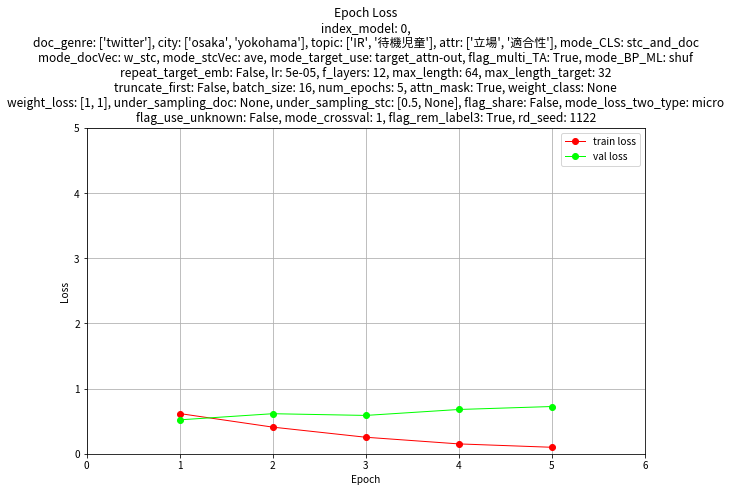

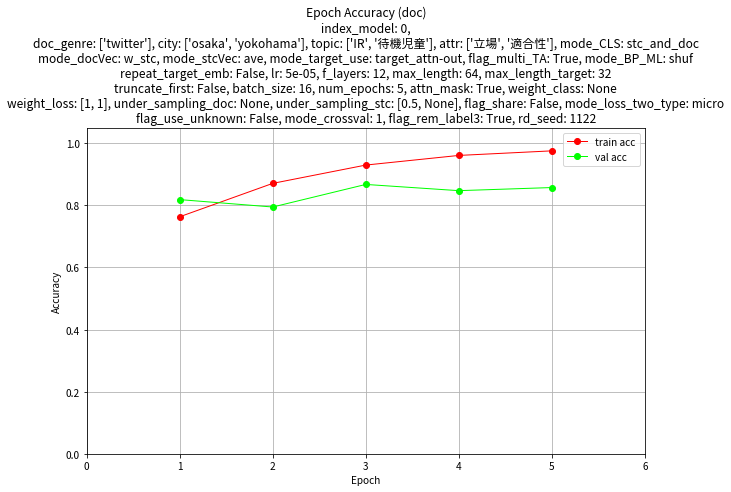

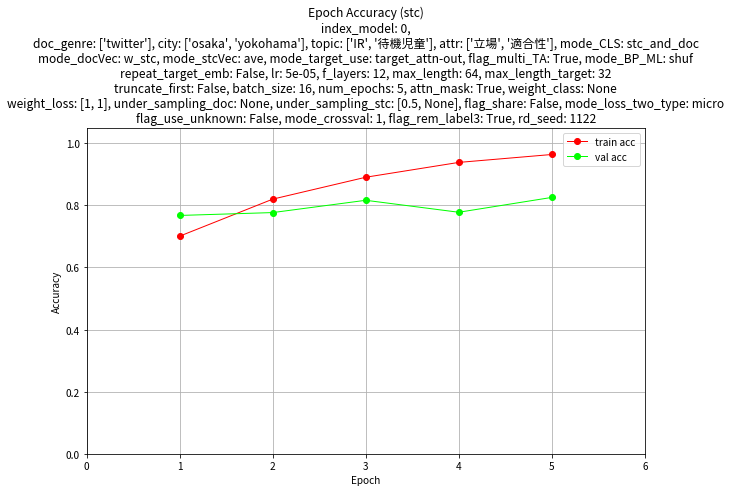

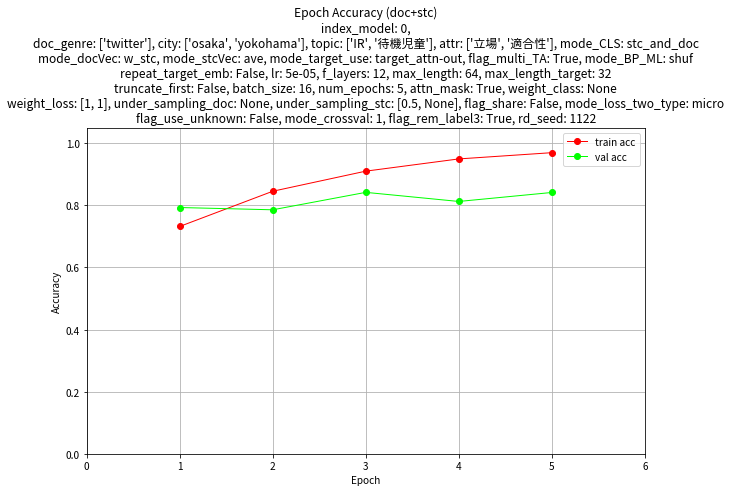

In [6]:

"""
グラフへ描画
"""
%matplotlib inline

#この結果を見て適切なエポック数を決める

# 日本語フォント対応にする
matplotlib.rc("font", family="Noto Sans CJK JP")

# グラフのタイトルにハイパーパラメータをいい感じに改行して表示するための文字列を作る
param_per_row = 5
hyper_params_items = list(hyper_params.items())
str_hyper_params = []
for i in range(0, len(hyper_params_items), param_per_row):
    str_hyper_params.append(", ".join(["{}: {}".format(k, v) for k, v in hyper_params_items[i: i + param_per_row]]))
str_hyper_params = "index_model: {},\n".format(index_model) + "\n".join(str_hyper_params)

# ロスの推移
title = "Epoch Loss\n{}".format(str_hyper_params)
x = [x for x in range(1, num_epochs + 1)]

# ロスのグラフのy軸の上限を決める
y_max = max(train_loss_list + val_loss_list)
ylim_top_list = [3] + [5 * (i + 2) for i in range(100)]
i = 0
while y_max + 0.5 >= ylim_top_list[i]:
    i += 1
ylim_top = ylim_top_list[i]
ylim_top = 5 # やっぱり固定
    
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, train_loss_list, "-", c="#ff0000", linewidth=1, marker='o')
ax.plot(x, val_loss_list, "-", c="#00ff00", linewidth=1, marker='o')
ax.grid(True)
ax.set_xlim(left=1, right=num_epochs)
ax.set_ylim(bottom=0, top=ylim_top)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(title)
plt.xticks(np.arange(0, num_epochs + 2, 1))
ax.legend(['train loss', 'val loss'])
plt.savefig("{}/Epoch_Loss_{}.png".format(path_dir_graph_epoch, index_model), bbox_inches='tight')
plt.show()

print("\n" + "=" * 100 + "\n")

# 正解率の推移

title_list = [
    "Epoch Accuracy (doc)\n{}".format(str_hyper_params) if flag_two_level else "Epoch Accuracy\n{}".format(str_hyper_params),
    "Epoch Accuracy (stc)\n{}".format(str_hyper_params),
    "Epoch Accuracy (doc+stc)\n{}".format(str_hyper_params)
]

y_list = [
    [train_acc_list, val_acc_list], [train_acc_list_sub, val_acc_list_sub], [train_acc_list_joint, val_acc_list_joint]
]

pathFile_list = [
    "{}/Epoch_Accuracy_doc_{}.png".format(path_dir_graph_epoch, index_model) if flag_two_level else "{}/Epoch_Accuracy_{}.png".format(path_dir_graph_epoch, index_model),
    "{}/Epoch_Accuracy_stc_{}.png".format(path_dir_graph_epoch, index_model),
    "{}/Epoch_Accuracy_joint_{}.png".format(path_dir_graph_epoch, index_model)
]

# 正解率の推移

count_graph = 0
for title, (y_1, y_2), path_file in myzip(title_list, y_list, pathFile_list):
    if not(flag_two_level) and count_graph > 0:
        break
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x, y_1, "-", c="#ff0000", linewidth=1, marker='o')
    ax.plot(x, y_2, "-", c="#00ff00", linewidth=1, marker='o')
    ax.grid(True)
    ax.set_xlim(left=1, right=num_epochs)
    ax.set_ylim(bottom=0, top=1.05)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title(title)
    plt.xticks(np.arange(0, num_epochs + 2, 1))
    ax.legend(['train acc', 'val acc'])
    plt.savefig(path_file, bbox_inches='tight')
    plt.show()

    count_graph += 1

In [7]:

"""
モデルの保存
"""

# ベストなロス，正解率
best_loss_val_epoch, best_loss_val = min([(i+1, v) for i, v in enumerate(val_loss_list)], key=lambda l: l[1])
best_acc_val_epoch, best_accuracy_val = max([(i+1, v) for i, v in enumerate(val_acc_list if not(flag_two_level) else val_acc_list_joint)], key=lambda l: l[1])

print("best_loss_val: {} ({} epoch)".format(best_loss_val, best_loss_val_epoch))
print("best_acc_val: {} ({} epoch)".format(best_accuracy_val, best_acc_val_epoch))

net_trained.load_state_dict(state_list[best_acc_val_epoch - 1])

# 過去のベスト正解率を上回るならモデルを保存
if flag_save_model:    
    # モデルの保存
    print("save model ({})...".format(path_model))
    with open(path_model, 'wb') as f:
        pickle.dump(net_trained, f)

    print("done")
else:
    print("skip save")

best_loss_val: 0.5206074633992704 (1 epoch)
best_acc_val: 0.8416476249694824 (3 epoch)
skip save


In [8]:
# アテンションを可視化するクラス
class AttentionVisualizer():
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    # HTML形式でAttentionを可視化した文を作成
    # sentence: テキスト(単語IDのリスト), weights: Attentionの重みリスト
    # index_token: どのトークンにおけるAttentionの可視化をしたいか (リストで複数のトークンをしていすると平均をとる)
    def highlight_text(self, sentence, weights, index_token=0):
        if type(index_token) is int:
            index_token = [index_token]
        
        # マルチヘッドの場合、全てのヘッドを足し合わせる
        if weights.dim() == 3:
            weights = weights.sum(dim=0)
        elif weights.dim() > 3:
            raise Exception("weightsの次元数が未対応 ()".format(weights.shape))
            
        # 対象のトークンの平均をとって，最大が1になるように正規化
        attens = weights[index_token].mean(dim=0)
        attens = attens / attens.max()
            
        html = ""
        
        sentence_str = self.tokenizer.convert_ids_to_tokens(sentence.tolist())
        for word_str, attn in myzip(sentence_str, attens):
            # 単語が[PAD]の場合は文章が終わりなのでbreak
            if word_str == "[PAD]":
                break

            # 関数highlightで色をつける
            html_color = '#%02X%02X%02X' % (255, int(255*(1 - attn)), int(255*(1 - attn)))
            html += '<span style="background-color: {}">{}</span>'.format(html_color, word_str.replace("##", ""))
#             html += '<span style="background-color: {}"> {}</span>'.format(html_color, word_str)
            
        html += "<br>"

        return html
    
# 各データの正解ラベル，予測ラベル，正答ID，誤りIDを保存するためのクラス
class Aggregater():
    def __init__(self, labelStr_list):
        self.y_true_dict = {} # {docID: label}
        self.y_pred_dict = {}

        self.y_true_dict_sub = {} # {docID: {stcID: label}}
        self.y_pred_dict_sub = {}

        self.label_trueIDset_dict = {index: set() for index, _ in enumerate(labelStr_list)} # {実際のラベル: 正しくそのラベルに予測されたIDの集合}の辞書
        self.label_falseIDset_dict = {index: set() for index, _ in enumerate(labelStr_list)} # {実際のラベル: そのラベルに予測されなかったIDの集合}の辞書
    
    # y_(true|pred)_dict(_sub)? を更新
    def store_label(self, ID, label, label_type, level):
        if level == "doc":
            if label_type == "true":
                self.y_true_dict[ID] = label
            elif label_type == "pred":
                self.y_pred_dict[ID] = label
            else:
                raise Exception("unknown label_type ({})".format(label_type))
        elif level == "stc":
            if label_type == "true":
                self.y_true_dict_sub[ID] = label
            elif label_type == "pred":
                self.y_pred_dict_sub[ID] = label
            else:
                raise Exception("unknown label_type ({})".format(label_type))
        else:
            raise Exception("unknown level ({})".format(level))
    
    # label_(true|false)IDset_dict を更新
    def add_ID(self, index_label, ID, judge):
        if judge == "true":
            self.label_trueIDset_dict[index_label].add(ID)
        elif judge == "false":
            self.label_falseIDset_dict[index_label].add(ID)
        else:
            raise Exception("unknown judge ({})".format(judge))
    
    def return_IDlabel_dict(self):
        return self.y_true_dict, self.y_pred_dict, self.y_true_dict_sub, self.y_pred_dict_sub
    
    def get_size(self):
        return {"doc_true": len(self.y_true_dict), "doc_pred": len(self.y_pred_dict), "stc_true": len(self.y_true_dict_sub), "stc_pred": len(self.y_pred_dict_sub)}
    

In [9]:

"""
テストデータで予測, 結果を集計
"""

# 平坦なリストを指定された形にネストする
def nest_data(lengths, *data):
    s = 0
    out = [[] for _ in range(len(data))]
    for length in lengths:
        for i in range(len(data)):
            out[i].append(data[i][s: s + length])
        s += length
    return out

# テストデータをモデルに入力する関数
def test_model(net, dataloaders_dict, target_attr_list, num_attr_one_record, 
               tokenizer, flag_two_level, flag_w_stc, mode_target_use, mode_BP_ML,
               aggregater_dict, ID_vec_dict, ID_attText_dict, ID_token_dict,
               ID_vec_dict_sub, ID_attText_dict_sub, weights_dict_stc,
               ID_attText_dict_target, ID_attText_dict_target_sub, ID_set_test,
               flag_visualize_attention):

    # Attention可視化インスタンス
    aver = AttentionVisualizer(tokenizer)
    
    #GPUが使えるならGPUにデータを送る
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.eval()   #モデルを検証モードに
    net.to(device)  #GPUが使えるならGPUへ送る

    #testデータのDataLoader
    for batch in tqdm(dataloaders_dict["test"]):
        #batchはTextとLableの辞書オブジェクト


        IDs = batch.ID.tolist() # ID
        topics = batch.TOPIC.tolist() # トピック

        if flag_two_level:
            inputs, lengths, _ = batch.TEXTs # 文書(文のリスト)
            inputs = torch.cat([inputs[:length] for inputs, length in myzip(inputs.to(device), lengths)], dim=0) # 平坦化(len(inputs) >= len(batch))

            IDs_sub = batch.IDs_sub # 文ID
            IDs_sub = [["{}-{}".format(i, t) for i in IDs_sub_i[IDs_sub_i >= -1]] for IDs_sub_i, t in myzip(IDs_sub, topics)] # トピックID付き

            labels_list = [] # [attr1の正解ラベルリスト(文書), attr2の属性ラベルリスト(文書)...]
            labels_list_sub = [] # [attr1の正解ラベルリスト(文,平坦化), attr2の属性ラベルリスト(文,平坦化)...]
            for index_attr in range(num_attr_one_record):
                labels_sub = getattr(batch, "LABELs_sub{}".format(index_attr+1 if index_attr else "")).to(device) # 文ラベル
                labels_sub = labels_sub[labels_sub >= -1]
                labels = getattr(batch, "LABEL{}".format(index_attr+1 if index_attr else "")).to(device)  # 文書ラベル

                labels_list.append(labels)
                labels_list_sub.append(labels_sub)
        else:
            inputs = batch.TEXT[0].to(device)  # テキスト(文or文書)
            labels_list = [] # [attr1の正解ラベルリスト, attr2の属性ラベルリスト...]
            for index_attr in range(num_attr_one_record):
                labels = getattr(batch, "LABEL{}".format(index_attr+1 if index_attr else "")).to(device)  # 文書ラベル
                labels_list.append(labels)

        IDs = ["{}-{}".format(i, t) for i, t in myzip(IDs, topics)] # トピックID付き
        topics = [topic_localID_dict[t] for t in topics]

        if mode_target_use:
            if flag_two_level:
                # トピックIDリストを文の数に合うように拡張
                topics = list(itertools.chain.from_iterable([[t] * length.item() for t, length in myzip(topics, lengths)]))
        else:
            topics = None

        if len(target_attr_list) >= 2 and mode_BP_ML == "shuf":
            attrs = [batch.ATTR[0].item()]
        else:
            attrs = list(range(len(target_attr_list)))

        #順伝搬（forward）計算
        with torch.set_grad_enabled(False):

            #BertForSNKに入力
            # weights_list: [
            #  入力文へのアテンション(batch_size, 12, max_length, max_length),
            #  各文の重み, 
            #  課題文へのアテンション(文数, max_length_input, max_length_target)]
            if flag_two_level:
                outputs_list, vecs, outputs_list_sub, vecs_sub, *weights_list = net(inputs, lengths=lengths, topics=topics, attrs=attrs, attention_show_flg=True)

                if flag_w_stc:
                    if "target_attn" in mode_target_use:
                        weights_list, weights_list_stc, weights_list_target = weights_list
                    else:
                        weights_list, weights_list_stc = weights_list
                else:
                    if "target_attn" in mode_target_use:
                        weights_list, weights_list_target = weights_list
                    else:
                        weights_list = weights_list[0]

                # 万が一, テキストがtruncateされてsepがなくなっていた場合, labels_subからtruncateされた文のラベルを削除
                if len(outputs_list_sub[0]) != len(labels_list_sub[0]):
                    raise Exception("出力された文数と正解ラベル数が違う（{}, {}）".format(len(outputs_list_sub[0]), len(labels_list_sub[0])))

            else:
                outputs_list, vecs, *weights_list = net(inputs, topics=topics, attrs=attrs, attention_show_flg=True)

                if "target_attn" in mode_target_use:
                    weights_list, weights_list_target = weights_list
                else:
                    weights_list = weights_list[0]

            if "target_attn" in mode_target_use:
                weights_list_target = torch.stack(weights_list_target, dim=1)
            vecs = vecs.permute(1, 0, 2)

            preds_list = [torch.max(outputs, 1)[1] for outputs in outputs_list]  #ラベルを予測(属性別)
            preds_list_T = list(myzip(*preds_list)) # [[attr1の予測ラベルリスト], [attr2のry]]
            labels_list_T = list(myzip(*labels_list)) # [[attr1の正解ラベルリスト], [attr2のry]]

            # 平坦化されている各種リストを各文書の文数に合うようにネスト
            if flag_two_level:
                vecs_sub = vecs_sub.permute(1, 0, 2)
                vecs_sub = nest_data(lengths, vecs_sub)[0]
                if "target_attn" in mode_target_use:
                    inputs, weights_list, weights_list_target = nest_data(lengths, inputs, weights_list, weights_list_target)
                else:
                    inputs, weights_list = nest_data(lengths, inputs, weights_list)

            # ID, テキスト(単語IDのリスト), 予測ラベル, 正解ラベル, テキストの分散表現, アテンションの重み(12基のリスト)
            for index_data, (ID, inputs_i, label_p_list, label_c_list, vecs_i, weights) in enumerate(myzip(IDs, inputs, preds_list_T, labels_list_T, vecs, weights_list)):
                for attr, vecs_ii in myzip(attrs, vecs_i):
                    ID_vec_dict[ID][attr] = vecs_ii.cpu().numpy()

                if flag_two_level:
                    if ID not in ID_vec_dict_sub:
                        ID_vec_dict_sub[ID] = [{} for _ in range(len(vecs_sub[index_data]))]
                    for i, vecs_sub_i in enumerate(vecs_sub[index_data]):
                        for attr, vec in myzip(attrs, vecs_sub_i):
                            ID_vec_dict_sub[ID][i][attr] = vec.cpu().numpy()

                label_p_list = [int(v) for v in label_p_list] # torch.tensor から int に変換
                label_c_list = [int(v) for v in label_c_list] # torch.tensor から int に変換

                # 文の重み
                if flag_w_stc:
                    for a, w in myzip(attrs, torch.flatten(weights_list_stc[index_data], start_dim=1).tolist()):
                        weights_dict_stc[ID][a] = w

                # 各種アテンションの可視化
                if flag_visualize_attention:
                    if not flag_two_level:
                        # 文書単位
                        html = aver.highlight_text(inputs_i, weights)
                        ID_attText_dict[ID] = html
                    else:
                        # 文単位
                        ID_attText_dict_sub[ID] = [aver.highlight_text(inputs_ii, weights_ii) for inputs_ii, weights_ii in myzip(inputs_i, weights)]

                    # ターゲット文
                    if "target_attn" in mode_target_use:
                        if not flag_two_level:
                            # 文書単位
                            input_ids_target_i = input_ids_target[topics[index_data]]
                            weights_target = weights_list_target[index_data]
                            for attr, weights_target_i in myzip(attrs, weights_target):
                                ID_attText_dict_target[ID][attr] = aver.highlight_text(input_ids_target_i, weights_target_i)
                        else:
                            # 文単位
                            input_ids_target_i = input_ids_target[topic_localID_dict[batch.TOPIC[index_data].item()]]
                            weights_target = weights_list_target[index_data].permute(1, 0, 2, 3)
                            for attr, weights_target_i in myzip(attrs[:num_TA], weights_target):
                                ID_attText_dict_target_sub[ID][attr] = []
                                for i, w in myzip(inputs_i, weights_target_i):
                                    # CLSによる分類の場合は，CLS -> 課題文へのアテンションを可視化 else 各トークンの平均
                                    tar_idxs_token = 0 if mode_docVec == "CLS" else i > 0
                                    ID_attText_dict_target_sub[ID][attr].append(aver.highlight_text(input_ids_target_i, w, tar_idxs_token))

                if not flag_two_level:
                    token = tokenizer.convert_ids_to_tokens(inputs_i.cpu().numpy())
                    ID_token_dict[ID] = "|".join(token)

                # 属性ID, 予測ラベル, 正解ラベル
                for index_attr, label_p, label_c in zip(attrs, label_p_list, label_c_list):
                    attr = target_attr_list[index_attr]
                    if not flag_use_unknown:
                        if label_p == label_c:
                            aggregater_dict[attr].add_ID(label_c, ID, "true")
                        else:
                            aggregater_dict[attr].add_ID(label_p, ID, "false")

                    aggregater_dict[attr].store_label(ID, label_c, "true", "doc")
                    aggregater_dict[attr].store_label(ID, label_p, "pred", "doc")

                ID_set_test.add(ID)

            if flag_two_level:
                # 文の属性ラベルを予測(属性別) 
                preds_list_sub = [torch.max(outputs_sub, 1)[1].tolist() for outputs_sub in outputs_list_sub]
                # 属性ID, 予測ラベルリスト(平坦), 正解ラベルリスト(平坦)
                for index_attr, preds_sub, labels_sub in myzip(attrs, preds_list_sub, labels_list_sub):
                    attr = target_attr_list[index_attr]
                    labels_sub = labels_sub.tolist()
                    preds_sub, labels_sub = nest_data(lengths, preds_sub, labels_sub)
                    for ID, IDs_sub_i, preds_sub_i, labels_sub_i in myzip(IDs, IDs_sub, preds_sub, labels_sub):
                        aggregater_dict[attr].store_label(ID, dict(myzip(IDs_sub_i, labels_sub_i)), "true", "stc")
                        aggregater_dict[attr].store_label(ID, dict(myzip(IDs_sub_i, preds_sub_i)), "pred", "stc")



In [10]:
# 属性別の集計器
aggregater_dict = {attr: Aggregater(labelStr_dict[attr]) for attr in target_attr_list}

ID_vec_dict = defaultdict(dict) # {ID: {attr: 分散表現}}の辞書
ID_attText_dict = {} # {ID: ハイライトされたテキスト}の辞書
ID_token_dict = {}

ID_vec_dict_sub = {} # {ID: [{attr: 文iの分散表現}]}の辞書
ID_attText_dict_sub = {} # {ID: [1つのSEPにおけるハイライトされたテキスト, 2つ目のSEP...]}の辞書
weights_dict_stc = defaultdict(dict) # {ID: {attr: [文iの重み]} }

ID_attText_dict_target = defaultdict(dict) # {ID: {attr: ターゲット文に対するアテンションの可視化}}
ID_attText_dict_target_sub = defaultdict(dict) # {ID: {attr: [1つのSEPにおけるターゲット文に対するハイライトされたテキスト, 2つ目のSEP...]}}

# テストデータのID一覧
ID_set_test = set()

if flag_use_unknown:
    flag_visualize_attention = False

print("テストデータで予測, 結果を集計...")
test_model(net_trained, dataloaders_dict, target_attr_list, num_attr_one_record, 
           tokenizer_bert, flag_two_level, flag_w_stc, mode_target_use, mode_BP_ML,
           aggregater_dict, ID_vec_dict, ID_attText_dict, ID_token_dict,
           ID_vec_dict_sub, ID_attText_dict_sub, weights_dict_stc,
           ID_attText_dict_target, ID_attText_dict_target_sub, ID_set_test,
           flag_visualize_attention)
print("done")


  0%|          | 0/67 [00:00<?, ?it/s]

テストデータで予測, 結果を集計...


100%|██████████| 67/67 [02:33<00:00,  2.29s/it]

done


In [11]:
{k: v.get_size() for k, v in aggregater_dict.items()}

{'立場': {'doc_true': 527, 'doc_pred': 527, 'stc_true': 527, 'stc_pred': 527},
 '適合性': {'doc_true': 534, 'doc_pred': 534, 'stc_true': 534, 'stc_pred': 534}}

In [12]:
# 各種評価指標を一括で計算
def eval_indexs(y_true, y_pred, labels):
    labels_int = list(range(len(labels)))
    cm = confusion_matrix(y_true, y_pred, labels=labels_int)
    cm_df = pd.DataFrame(cm, columns=labels, index=labels)
    cm_df["total"] = cm_df.sum(axis=1)
    cm_df.loc["total"] = cm_df.sum(axis=0)

    macro_ave_dict = {}

    # 正解率
    accuracy = accuracy_score(y_true, y_pred)

    # 適合率
    prec_list = precision_score(y_true, y_pred, average=None, labels=labels_int, zero_division=0).tolist()
    prec_dict = {s: v for s, v in myzip(labels, prec_list)}
    macro_ave_dict["precision"] = precision_score(y_true, y_pred, average="macro", labels=labels_int, zero_division=0)

    # 再現率
    recall_list = recall_score(y_true, y_pred, average=None, labels=labels_int, zero_division=0).tolist()
    recall_dict = {s: v for s, v in myzip(labels, recall_list)}
    macro_ave_dict["recall"] = recall_score(y_true, y_pred, average="macro", labels=labels_int, zero_division=0)

    # f1
    f1_list = f1_score(y_true, y_pred, average=None, labels=labels_int, zero_division=0).tolist()
    f1_dict = {s: v for s, v in myzip(labels, f1_list)}
    macro_ave_dict["f1"] = f1_score(y_true, y_pred, average="macro", labels=labels_int, zero_division=0)
    
    return {"cm": {"ndarray": cm, "df": cm_df}, "acc": accuracy, "prec": prec_dict, "recall": recall_dict, "f1": f1_dict, "macro_ave": macro_ave_dict}

In [21]:

"""
各評価値を計算, 正解or不正解データ表示
"""
pd.set_option('display.unicode.east_asian_width', True)

target_ID_set = {}

# visualize_attention = True
view_true = True # 正解したデータを表示するか
view_false = True # 不正解のデータを表示するか

rate_view_true =  0.01 # 表示する正解データの割合
rate_view_false =  0.01 # 表示する不正解データの割合

lowerLim_viewTrue = 1 # 最低限表示する正解データの数
lowerLim_viewFalse = 1 # 最低限表示する不正解データの数

print("##### index_model: {} #####".format(index_model))

result_testData_by_attr = {} # {attr: 評価値(dict)}
for attr, aggregater in aggregater_dict.items():
    print("\nxxxxxxxxxxxxxxxxxxxxxxxx {} xxxxxxxxxxxxxxxxxxxxxxxx".format(attr))
    y_true_dict, y_pred_dict, y_true_dict_sub, y_pred_dict_sub = aggregater.return_IDlabel_dict()
    labelStr_list = labelStr_dict[attr]
    y_true_list = list(y_true_dict.values())
    y_pred_list = list(y_pred_dict.values())

    y_true_list_sub = sum([list(d.values()) for d in y_true_dict_sub.values()], [])
    y_pred_list_sub = sum([list(d.values()) for d in y_pred_dict_sub.values()], [])

    if not flag_use_unknown:
        # 評価指標
        eval_result = eval_indexs(y_true_list, y_pred_list, labelStr_list)

        # 混同行列 
        cm = eval_result["cm"]["ndarray"]
        cm_df = eval_result["cm"]["df"]
        label_freq_teach = cm_df.sum(axis=1).to_dict()
        label_freq_pred = cm_df.sum(axis=0).to_dict()

        accuracy = eval_result["acc"] # 正解率
        prec_dict = eval_result["prec"] # 適合率
        recall_dict = eval_result["recall"] # 再現率
        f1_dict = eval_result["f1"] # f1
        macro_ave_dict = eval_result["macro_ave"] # マクロ平均

        if flag_two_level:
            print("***** doc *****")
        print("混同行列\n{}".format(cm_df))
        print("データ数: {} 計: {}".format(label_freq_teach, len(y_true_list)))
        print("予測件数: {} 計: {}".format(label_freq_pred, len(y_pred_list)))
        print("-" * 100)

        print("正解率: {}".format(accuracy))
        print("適合率: {}".format(prec_dict))
        print("再現率: {}".format(recall_dict))
        print("F1: {}".format(f1_dict))
        print("マクロ平均: {}".format(macro_ave_dict))
        
        # トピック別評価
        if len(target_topic_list) > 1:
            # {topic: [[y_true], [y_pred]]}
            y_list_by_topic = {
                topic: list(myzip(*[[value, y_pred_dict[ID]] for ID, value in y_true_dict.items() if ID_topic_dict[ID] == index_t])) for index_t, topic in enumerate(topic_list) if topic in target_topic_list
            }
            eval_result_by_topic = {topic: eval_indexs(l1, l2, labelStr_list) for topic, (l1, l2) in y_list_by_topic.items()}
            acc_by_topic_df = pd.Series({t: e["acc"] for t, e in eval_result_by_topic.items()}).T
            prec_by_topic_df = pd.DataFrame({t: e["prec"] for t, e in eval_result_by_topic.items()}).T
            recall_by_topic_df = pd.DataFrame({t: e["recall"] for t, e in eval_result_by_topic.items()}).T
            f1_by_topic_df = pd.DataFrame({t: e["f1"] for t, e in eval_result_by_topic.items()}).T
            macro_ave_by_topic_df = pd.DataFrame({t: e["macro_ave"] for t, e in eval_result_by_topic.items()}).T

            print("\n--- トピック別 ---")
            print("[正解率]")
            print(acc_by_topic_df)
            print("------\n[適合率]")
            print(prec_by_topic_df)
            print("------\n[再現率]")
            print(recall_by_topic_df)
            print("------\n[F1]")
            print(f1_by_topic_df)
            print("------\n[マクロ平均]")
            print(macro_ave_by_topic_df)

        if flag_two_level:
            # 文単位
            eval_result_sub = eval_indexs(y_true_list_sub, y_pred_list_sub, labelStr_list)
            cm_sub = eval_result_sub["cm"]["ndarray"]
            cm_df_sub = eval_result_sub["cm"]["df"]
            label_freq_teach_sub = cm_df_sub.sum(axis=1).to_dict()
            label_freq_pred_sub = cm_df_sub.sum(axis=0).to_dict()

            accuracy_sub = eval_result_sub["acc"]
            prec_dict_sub = eval_result_sub["prec"]
            recall_dict_sub = eval_result_sub["recall"]
            f1_dict_sub = eval_result_sub["f1"]
            macro_ave_dict_sub = eval_result_sub["macro_ave"]

            print("=" * 100)
            print("***** stc *****")
            print("混同行列\n{}".format(cm_df_sub))
            print("データ数: {} 計: {}".format(label_freq_teach_sub, len(y_true_list_sub)))
            print("予測件数: {} 計: {}".format(label_freq_pred_sub, len(y_pred_list_sub)))
            print("-" * 100)

            print("正解率: {}".format(accuracy_sub))
            print("適合率: {}".format(prec_dict_sub))
            print("再現率: {}".format(recall_dict_sub))
            print("F1: {}".format(f1_dict_sub))
            print("マクロ平均: {}".format(macro_ave_dict_sub))

            # トピック別評価
            if len(target_topic_list) > 1:
                # {topic: [[y_true], [y_pred]]}
                y_list_by_topic_sub = {
                    topic: list(myzip(*[[list(values.values()), list(y_pred_dict_sub[ID].values())] for ID, values in y_true_dict_sub.items() if ID_topic_dict[ID] == index_t])) for index_t, topic in enumerate(topic_list) if topic in target_topic_list
                }
                y_list_by_topic_sub = {ID: [sum(l, []) for l in values] for ID, values in y_list_by_topic_sub.items()}
                eval_result_by_topic_sub = {topic: eval_indexs(l1, l2, labelStr_list) for topic, (l1, l2) in y_list_by_topic_sub.items()}
                acc_by_topic_df_sub = pd.Series({t: e["acc"] for t, e in eval_result_by_topic_sub.items()}).T
                prec_by_topic_df_sub = pd.DataFrame({t: e["prec"] for t, e in eval_result_by_topic_sub.items()}).T
                recall_by_topic_df_sub = pd.DataFrame({t: e["recall"] for t, e in eval_result_by_topic_sub.items()}).T
                f1_by_topic_df_sub = pd.DataFrame({t: e["f1"] for t, e in eval_result_by_topic_sub.items()}).T
                macro_ave_by_topic_df_sub = pd.DataFrame({t: e["macro_ave"] for t, e in eval_result_by_topic_sub.items()}).T

                print("\n--- トピック別 ---")
                print("[正解率]")
                print(acc_by_topic_df_sub)
                print("------\n[適合率]")
                print(prec_by_topic_df_sub)
                print("------\n[再現率]")
                print(recall_by_topic_df_sub)
                print("------\n[F1]")
                print(f1_by_topic_df_sub)
                print("------\n[マクロ平均]")
                print(macro_ave_by_topic_df_sub)

            # 文 + 文書
            accuracy_joint = (accuracy + accuracy_sub) / 2
            prec_dict_joint = {label_str: (prec_dict[label_str] + prec_dict_sub[label_str]) / 2 for label_str in labelStr_list}
            recall_dict_joint = {label_str: (recall_dict[label_str] + recall_dict_sub[label_str]) / 2 for label_str in labelStr_list}
            f1_dict_joint = {label_str: (f1_dict[label_str] + f1_dict_sub[label_str]) / 2 for label_str in labelStr_list}
            macro_ave_dict_joint = {n: sum(d.values()) / len(d) for n, d in myzip(["precision", "recall", "f1"], [prec_dict_joint, recall_dict_joint, f1_dict_joint])}

            print("=" * 100)
            print("***** stc + doc (macro average) *****")
            print("正解率: {}".format(accuracy_joint))
            print("適合率: {}".format(prec_dict_joint))
            print("再現率: {}".format(recall_dict_joint))
            print("F1: {}".format(f1_dict_joint))
            print("マクロ平均: {}".format(macro_ave_dict_joint))

            # トピック別評価
            if len(target_topic_list) > 1:
                print("\n--- トピック別 ---")
                acc_by_topic_df_joint = (acc_by_topic_df + acc_by_topic_df_sub) / 2
                prec_by_topic_df_joint = (prec_by_topic_df + prec_by_topic_df_sub) / 2
                recall_by_topic_df_joint = (recall_by_topic_df + recall_by_topic_df_sub) / 2
                f1_by_topic_df_joint = (f1_by_topic_df + f1_by_topic_df_sub) / 2
                macro_ave_by_topic_df_joint = (macro_ave_by_topic_df + macro_ave_by_topic_df_sub) / 2

                print("[正解率]")
                print(acc_by_topic_df_joint)
                print("------\n[適合率]")
                print(prec_by_topic_df_joint)
                print("------\n[再現率]")
                print(recall_by_topic_df_joint)
                print("------\n[F1]")
                print(f1_by_topic_df_joint)
                print("------\n[マクロ平均]")
                print(macro_ave_by_topic_df_joint)

    else:
        count_label = Counter(y_pred_list)
        count_label = {s: count_label[i] for i, s in enumerate(labelStr_list)}
        print(count_label)
    
    if not flag_use_unknown:
        if flag_two_level:
            result_testData = {
                "doc": {"confusion_matrix": cm.tolist(), "num_teach": label_freq_teach, "num_pred": label_freq_pred,
                        "accuracy": accuracy, "precision": prec_dict,
                        "recall": recall_dict, "f1": f1_dict, "macro_average": macro_ave_dict},
                "stc": {"confusion_matrix": cm_sub.tolist(), "num_teach": label_freq_teach_sub, "num_pred": label_freq_pred_sub,
                        "accuracy": accuracy_sub, "precision": prec_dict_sub,
                        "recall": recall_dict_sub, "f1": f1_dict_sub, "macro_average": macro_ave_dict_sub},
                "joint": {"accuracy": accuracy_joint, "precision": prec_dict_joint,
                        "recall": recall_dict_joint, "f1": f1_dict_joint, "macro_average": macro_ave_dict_joint}
            }
        else:
            result_testData = {"confusion_matrix": cm.tolist(), "num_teach": label_freq_teach, "num_pred": label_freq_pred,
                               "accuracy": accuracy, "precision": prec_dict,
                               "recall": recall_dict, "f1": f1_dict, "macro_average": macro_ave_dict}

        if len(target_topic_list) > 1:
            if flag_two_level:
                result_testData["by_topic"] = {
                    "doc": {"accuracy": acc_by_topic_df.T.to_dict(), "precision": prec_by_topic_df.T.to_dict(), "recall": recall_by_topic_df.T.to_dict(),
                            "f1": f1_by_topic_df.T.to_dict(), "macro_average": macro_ave_by_topic_df.T.to_dict()},
                    "stc": {"accuracy": acc_by_topic_df_sub.T.to_dict(), "precision": prec_by_topic_df_sub.T.to_dict(), "recall": recall_by_topic_df_sub.T.to_dict(),
                            "f1": f1_by_topic_df_sub.T.to_dict(), "macro_average": macro_ave_by_topic_df_sub.T.to_dict()},
                    "joint": {"accuracy": acc_by_topic_df_joint.T.to_dict(), "precision": prec_by_topic_df_joint.T.to_dict(), "recall": recall_by_topic_df_joint.T.to_dict(),
                              "f1": f1_by_topic_df_joint.T.to_dict(), "macro_average": macro_ave_by_topic_df_joint.T.to_dict()},
                }
            else:
                result_testData["by_topic"] = {"accuracy": acc_by_topic_df.T.to_dict(), "precision": prec_by_topic_df.T.to_dict(), "recall": recall_by_topic_df.T.to_dict(),
                                               "f1": f1_by_topic_df.T.to_dict(), "macro_average": macro_ave_by_topic_df.T.to_dict()}
    else:
        result_testData = {"num_pred": count_label}
    
    result_testData_by_attr[attr] = result_testData
    
# 学習結果を保存
if flag_save_history:
    result = {"hyper_params": hyper_params,
              "best_loss_val": {"value": best_loss_val, "epoch": best_loss_val_epoch},
              "best_accuracy_val": {"value": best_accuracy_val, "epoch": best_acc_val_epoch},
              "test_data": result_testData_by_attr}
    
    if not os.path.isfile(path_history):
        with open(path_history, "w", encoding="utf-8") as f:
            json.dump({}, f)
        
    shutil.copyfile(path_history, path_history_copy)

    with open(path_history, "r+", encoding="utf-8") as f:
        fcntl.flock(f.fileno(), fcntl.LOCK_EX)
        index_result_dict = json.load(f)
        f.truncate(0)
        f.seek(0)
        index_result_dict[index_model] = result
        json.dump(index_result_dict, f, indent=4)
        fcntl.flock(f.fileno(), fcntl.LOCK_UN)
        

print("\n" + "=" * 100 + "\n")

y_true_dict, y_pred_dict, y_true_dict_sub, y_pred_dict_sub = aggregater_dict[main_attr].return_IDlabel_dict()
label_trueIDset_dict = aggregater_dict[main_attr].label_trueIDset_dict
label_falseIDset_dict = aggregater_dict[main_attr].label_falseIDset_dict
labelStr_list = labelStr_dict[main_attr]

# 正解or不正解データ表示(ハイライトするならする)
# ラベルでループ
for label, labelStr in enumerate(labelStr_list):
    IDset_list = []
    judge_list = [1]
    
    if view_true: IDset_list.append(("正解", rate_view_true, lowerLim_viewTrue, label_trueIDset_dict[label]))
    if view_false: IDset_list.append(("不正解", rate_view_false, lowerLim_viewFalse, label_falseIDset_dict[label]))

    # ("不正解" or "正解"), 表示する割合, 表示数下限, 当該ID集合でループ
    for judge, rate, lowerLim, IDset in IDset_list:
        print("カテゴリ [{}] の{}データ\n".format(labelStr, judge))
        
        for path_file in file_dict["test"]:
            if main_attr not in path_file:
                continue
            
            topic = [t for t in target_topic_list if t in path_file][0]
            
            print("***** {} *****".format(path_file))
            with open(path_file, "r", encoding='utf-8') as f_i:
                reader = csv.reader(f_i, delimiter='\t')

                # 描画した回数
                count_view = 0

                for row in reader:
                    if flag_two_level:
                        ID, IDs_sub, text, _, label_true, _ = row
                    else:
                        ID, text, label_true, _ = row
                    ID = "{}-{}".format(ID, topic_dict[topic])
                    if flag_rem_label3 and ID not in y_true_dict:
                        print("warning: skip (ID:{}, file:{})".format(ID, path_file))
                        continue

                    if flag_two_level:
                        judge_list = [1 if x == y else 0 for x, y in myzip(y_true_dict_sub[ID].values(), y_pred_dict_sub[ID].values())]
                    
                    if ID in IDset:
                        pred_labelStr = labelStr_list[y_pred_dict[ID]]

                        if count_view < lowerLim or random.random() < rate or ID in target_ID_set:
                            print("ID:", ID)
                            
                            # 文書の表示
                            if flag_visualize_attention:
                                # Attention可視化
                                if "target_attn" in mode_target_use and not(flag_two_level):
                                    print("target:")
                                    for i in range(num_TA):
                                        if flag_multi_TA:
                                            print("   [{}]".format(labelStr_list[i]))
                                        display(HTML(ID_attText_dict_target[ID][i]))
                                    print()
                                if not flag_two_level:
                                    print("text:")
                                    display(HTML(ID_attText_dict[ID]))
                                    
                            else:
                                if not(flag_two_level):
                                    # アテンション可視化なし．普通の表示
                                    print("text:", text)
                                    
                            if flag_w_stc:
                                if flag_multi_TA:
                                    print("stc weight:")
                                    
                                    for i in range(num_TA):
                                        if flag_multi_TA:
                                            print("   {}: {}".format(target_attr_list[i], weights_dict_stc[ID][i]))
                                        else:
                                            print(weights_dict_stc[ID][i])
                                else:
                                    print("stc weight: {}".format(weights_dict_stc[ID]))
                                    
                            # 文の表示
                            if flag_two_level:
                                print("doc: {} ({}), ".format(pred_labelStr, judge), end="")
                                for a in target_attr_list[1:]:
                                    p, t = aggregater_dict[a].y_pred_dict[ID], aggregater_dict[a].y_true_dict[ID]
                                    print(labelStr_dict[a][p], "(正解)" if p == t else "(不正解)", end=", ")
                                print()
                                print("-" * 30)
                                
                                for index_stc, (html, p, j) in enumerate(myzip(ID_attText_dict_sub[ID], y_pred_dict_sub[ID].values(), judge_list)):
                                    print("{}文目: {} ({}), ".format(index_stc + 1, labelStr_list[p], ("不正解", "正解")[j]), end="")
                                    for a in target_attr_list[1:]:
                                        p, t = list(aggregater_dict[a].y_pred_dict_sub[ID].values())[index_stc], list(aggregater_dict[a].y_true_dict_sub[ID].values())[index_stc]
                                        print(labelStr_dict[a][p], "(正解)" if p == t else "(不正解)", end=", ")
                                    print()
                                        
                                    if ID in ID_attText_dict_target_sub:
                                        print("target:")
                                        for i in range(num_TA):
                                            if flag_multi_TA:
                                                print("   [{}]".format(target_attr_list[i]))
                                            display(HTML(ID_attText_dict_target_sub[ID][i][index_stc]))
                                        print()

                                    print("input:")
                                    display(HTML(html))
                                    print("-----")
                            else:
                                print("prediction: {} ({}), ".format(pred_labelStr, judge), end="")
                                for a in target_attr_list[1:]:
                                    p, t = aggregater_dict[a].y_pred_dict[ID], aggregater_dict[a].y_true_dict[ID]
                                    print(labelStr_dict[a][p], "(正解)" if p == t else "(不正解)", end=", ")
                                print("\n")
                            
                            print("-" * 100)
                            count_view += 1

            print("=" * 100)
    print("#" * 100)



##### index_model: 0 #####

xxxxxxxxxxxxxxxxxxxxxxxx 立場 xxxxxxxxxxxxxxxxxxxxxxxx
***** doc *****
混同行列
          立場なし  賛成  反対  total
立場なし       124     5   126    255
賛成             6    11    29     46
反対            12     1   213    226
total          142    17   368    527
データ数: {'立場なし': 510, '賛成': 92, '反対': 452, 'total': 1054} 計: 527
予測件数: {'立場なし': 284, '賛成': 34, '反対': 736, 'total': 1054} 計: 527
----------------------------------------------------------------------------------------------------
正解率: 0.6603415559772297
適合率: {'立場なし': 0.8732394366197183, '賛成': 0.6470588235294118, '反対': 0.5788043478260869}
再現率: {'立場なし': 0.48627450980392156, '賛成': 0.2391304347826087, '反対': 0.9424778761061947}
F1: {'立場なし': 0.6246851385390428, '賛成': 0.34920634920634924, '反対': 0.7171717171717171}
マクロ平均: {'precision': 0.6997008693250724, 'recall': 0.5559609402309084, 'f1': 0.5636877349723698}

--- トピック別 ---
[正解率]
待機児童    0.56250
IR          0.74216
dtype: float64
------
[適合率]
          立場なし      賛成      反対
待

   [適合性]



input:


-----
2文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
3文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
***** ../annotation/file_crossval/stc_and_doc/twitter_yokohama_待機児童_立場_stc_and_doc_test-1.tsv *****
ID: 879-0
stc weight:
   立場: [1.0]
   適合性: [1.0]
doc: 立場なし (正解), 有り (不正解), 
------------------------------
1文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
***** ../annotation/file_crossval/stc_and_doc/twitter_osaka_IR_立場_stc_and_doc_test-1.tsv *****
ID: 155529-1
stc weight:
   立場: [1.0]
   適合性: [1.0]
doc: 立場なし (正解), 有り (不正解), 
------------------------------
1文目: 立場なし (正解), 有り (不正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
***** ../annotation/file_crossval/stc_and_doc/twitter_osaka_待機児童_立場_stc_and_doc_test-1.tsv *****
ID: 325765-0
stc weight:
   立場: [1.0]
   適合性: [1.0]
doc: 立場なし (正解), 無し (正解), 
------------------------------
1文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
カテゴリ [立場なし] の不正解データ

***** ../annotation/file_crossval/stc_and_doc/twitter_yokohama_IR_立場_stc_and_doc_test-1.tsv *****
ID: 20195-1
stc weight:
   立場: [0.12359059602022171, 0.11895529925823212, 0.40091097354888916, 0.3565431535243988]
   適合性: [0.05825483053922653, 0.13026942312717438, 0.5004766583442688, 0.3109990656375885]
doc: 立場なし (不正解), 有り (正解), 
------------------------------
1文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
2文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
3文目: 立場なし (不正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
4文目: 立場なし (正解), 有り (不正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
***** ../annotation/file_crossval/stc_and_doc/twitter_yokohama_待機児童_立場_stc_and_doc_test-1.tsv *****
ID: 1143-0
stc weight:
   立場: [0.2838647961616516, 0.7161352038383484]
   適合性: [0.11916014552116394, 0.8808398842811584]
doc: 立場なし (不正解), 有り (正解), 
------------------------------
1文目: 立場なし (不正解), 無し (不正解), 
target:
   [立場]


   [適合性]



input:


-----
2文目: 立場なし (不正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
***** ../annotation/file_crossval/stc_and_doc/twitter_osaka_IR_立場_stc_and_doc_test-1.tsv *****
ID: 151683-1
stc weight:
   立場: [1.0]
   適合性: [1.0]
doc: 立場なし (不正解), 有り (正解), 
------------------------------
1文目: 立場なし (不正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
***** ../annotation/file_crossval/stc_and_doc/twitter_osaka_待機児童_立場_stc_and_doc_test-1.tsv *****
ID: 325760-0
stc weight:
   立場: [0.31990811228752136, 0.48398682475090027, 0.047601375728845596, 0.07999920099973679, 0.05425465852022171, 0.01424974575638771]
   適合性: [0.5967293977737427, 0.23944145441055298, 0.06741993874311447, 0.04081639647483826, 0.029657762497663498, 0.02593505010008812]
doc: 立場なし (不正解), 有り (正解), 
------------------------------
1文目: 反対 (不正解), 有り (不正解), 
target:
   [立場]


   [適合性]



input:


-----
2文目: 反対 (正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
3文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
4文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
5文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
6文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
####################################################################################################
カテゴリ [賛成] の正解データ

***** ../annotation/file_crossval/stc_and_doc/twitter_yokohama_IR_立場_stc_and_doc_test-1.tsv *****
ID: 31877-1
stc weight:
   立場: [0.003079848363995552, 0.9969202280044556]
   適合性: [0.0016642878763377666, 0.9983357787132263]
doc: 賛成 (正解), 有り (正解), 
------------------------------
1文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
2文目: 賛成 (正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
***** ../annotation/file_crossval/stc_and_doc/twitter_yokohama_待機児童_立場_stc_and_doc_test-1.tsv *****
***** ../annotation/file_crossval/stc_and_doc/twitter_osaka_IR_立場_stc_and_doc_test-1.tsv *****
ID: 330147-1
stc weight:
   立場: [0.9814178347587585, 0.018582161515951157]
   適合性: [0.9904133677482605, 0.009586643427610397]
doc: 賛成 (正解), 有り (正解), 
------------------------------
1文目: 賛成 (不正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
2文目: 立場なし (不正解), 無し (不正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
***** ../annotation/file_crossval/stc_and_doc/twitter_osaka_待機児童_立場_stc_and_doc_test-1.tsv *****
ID: 325775-0
stc weight:
   立場: [0.22302329540252686, 0.7769767045974731]
   適合性: [0.13592396676540375, 0.8640760183334351]
doc: 賛成 (正解), 有り (正解), 
------------------------------
1文目: 立場なし (不正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
2文目: 賛成 (正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
カテゴリ [賛成] の不正解データ

***** ../annotation/file_crossval/stc_and_doc/twitter_yokohama_IR_立場_stc_and_doc_test-1.tsv *****
ID: 10298-1
stc weight:
   立場: [0.06971099227666855, 0.8956660032272339, 0.015744391828775406, 0.014403059147298336, 0.004475520458072424]
   適合性: [0.10161130130290985, 0.8666166067123413, 0.010820338502526283, 0.011993126943707466, 0.008958659134805202]
doc: 賛成 (不正解), 有り (正解), 
------------------------------
1文目: 立場なし (不正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
2文目: 賛成 (不正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
3文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
4文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
5文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
***** ../annotation/file_crossval/stc_and_doc/twitter_yokohama_待機児童_立場_stc_and_doc_test-1.tsv *****
***** ../annotation/file_crossval/stc_and_doc/twitter_osaka_IR_立場_stc_and_doc_test-1.tsv *****
ID: 157008-1
stc weight:
   立場: [0.9786970615386963, 0.004379166290163994, 0.01692381501197815]
   適合性: [0.9858077764511108, 0.0056119030341506, 0.00858034286648035]
doc: 賛成 (不正解), 有り (正解), 
------------------------------
1文目: 賛成 (不正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
2文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
3文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
***** ../annotation/file_crossval/stc_and_doc/twitter_osaka_待機児童_立場_stc_and_doc_test-1.tsv *****
ID: 325801-0
stc weight:
   立場: [0.774418294429779, 0.22558175027370453]
   適合性: [0.5327876210212708, 0.46721240878105164]
doc: 賛成 (不正解), 有り (正解), 
------------------------------
1文目: 立場なし (正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
2文目: 立場なし (正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
####################################################################################################
カテゴリ [反対] の正解データ

***** ../annotation/file_crossval/stc_and_doc/twitter_yokohama_IR_立場_stc_and_doc_test-1.tsv *****
ID: 27201-1
stc weight:
   立場: [0.15235647559165955, 0.206746906042099, 0.0009084923658519983, 0.6399880647659302]
   適合性: [0.24395282566547394, 0.04876365512609482, 0.0011916509829461575, 0.7060918211936951]
doc: 反対 (正解), 有り (正解), 
------------------------------
1文目: 反対 (不正解), 有り (不正解), 
target:
   [立場]


   [適合性]



input:


-----
2文目: 反対 (不正解), 有り (不正解), 
target:
   [立場]


   [適合性]



input:


-----
3文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
4文目: 反対 (正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
***** ../annotation/file_crossval/stc_and_doc/twitter_yokohama_待機児童_立場_stc_and_doc_test-1.tsv *****
ID: 699-0
stc weight:
   立場: [0.010028224438428879, 0.26552289724349976, 0.07901369035243988, 0.6374489068984985, 0.007986278273165226]
   適合性: [0.042545247822999954, 0.138459712266922, 0.08366045355796814, 0.7248382568359375, 0.010496364906430244]
doc: 反対 (正解), 有り (正解), 
------------------------------
1文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
2文目: 反対 (不正解), 有り (不正解), 
target:
   [立場]


   [適合性]



input:


-----
3文目: 反対 (不正解), 無し (不正解), 
target:
   [立場]


   [適合性]



input:


-----
4文目: 反対 (正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
5文目: 立場なし (不正解), 無し (不正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
ID: 973-0
stc weight:
   立場: [0.9117822051048279, 0.051112208515405655, 0.02743404172360897, 0.009671438485383987]
   適合性: [0.8107848763465881, 0.0714469626545906, 0.07327865809202194, 0.04448944330215454]
doc: 反対 (正解), 有り (正解), 
------------------------------
1文目: 反対 (正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
2文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
3文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
4文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
***** ../annotation/file_crossval/stc_and_doc/twitter_osaka_IR_立場_stc_and_doc_test-1.tsv *****
ID: 151647-1
stc weight:
   立場: [0.0012423032894730568, 0.001026142854243517, 0.9341163635253906, 0.06361515820026398]
   適合性: [0.0011357797775417566, 0.001964138587936759, 0.9088626503944397, 0.08803737163543701]
doc: 反対 (正解), 有り (正解), 
------------------------------
1文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
2文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
3文目: 反対 (正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
4文目: 立場なし (正解), 有り (不正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
ID: 156917-1
stc weight:
   立場: [1.0]
   適合性: [1.0]
doc: 反対 (正解), 有り (正解), 
------------------------------
1文目: 反対 (正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
***** ../annotation/file_crossval/stc_and_doc/twitter_osaka_待機児童_立場_stc_and_doc_test-1.tsv *****
ID: 325831-0
stc weight:
   立場: [0.8830524682998657, 0.11694751679897308]
   適合性: [0.6102680563926697, 0.3897319734096527]
doc: 反対 (正解), 有り (正解), 
------------------------------
1文目: 反対 (正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
2文目: 反対 (正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
ID: 325850-0
stc weight:
   立場: [1.0]
   適合性: [1.0]
doc: 反対 (正解), 有り (正解), 
------------------------------
1文目: 反対 (正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
ID: 149448-0
stc weight:
   立場: [0.020500680431723595, 0.05096974968910217, 0.05656574293971062, 0.8719638586044312]
   適合性: [0.059849947690963745, 0.08242791146039963, 0.08623982965946198, 0.7714822888374329]
doc: 反対 (正解), 有り (正解), 
------------------------------
1文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
2文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
3文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
4文目: 反対 (正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
ID: 149544-0
stc weight:
   立場: [0.8643891215324402, 0.13561081886291504]
   適合性: [0.7881134152412415, 0.21188665926456451]
doc: 反対 (正解), 有り (正解), 
------------------------------
1文目: 反対 (正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
2文目: 反対 (正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
カテゴリ [反対] の不正解データ

***** ../annotation/file_crossval/stc_and_doc/twitter_yokohama_IR_立場_stc_and_doc_test-1.tsv *****
ID: 31963-1
stc weight:
   立場: [1.0]
   適合性: [1.0]
doc: 反対 (不正解), 有り (正解), 
------------------------------
1文目: 反対 (不正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
ID: 17509-1
stc weight:
   立場: [0.9981169700622559, 0.001883031683973968]
   適合性: [0.9986993074417114, 0.0013006835943087935]
doc: 反対 (不正解), 有り (正解), 
------------------------------
1文目: 反対 (不正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
2文目: 立場なし (正解), 無し (不正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
***** ../annotation/file_crossval/stc_and_doc/twitter_yokohama_待機児童_立場_stc_and_doc_test-1.tsv *****
ID: 499-0
stc weight:
   立場: [0.001499067060649395, 0.009543533436954021, 0.010574483312666416, 0.9783828854560852]
   適合性: [0.031336717307567596, 0.038853030651807785, 0.09739001840353012, 0.832420289516449]
doc: 反対 (不正解), 有り (正解), 
------------------------------
1文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
2文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
3文目: 立場なし (正解), 有り (不正解), 
target:
   [立場]


   [適合性]



input:


-----
4文目: 反対 (不正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
ID: 1171-0
stc weight:
   立場: [0.42293688654899597, 0.26019200682640076, 0.29832154512405396, 0.01854952797293663]
   適合性: [0.2976651191711426, 0.2608790099620819, 0.33224058151245117, 0.10921531915664673]
doc: 反対 (不正解), 有り (正解), 
------------------------------
1文目: 反対 (不正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
2文目: 反対 (不正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
3文目: 反対 (不正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
4文目: 立場なし (正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
***** ../annotation/file_crossval/stc_and_doc/twitter_osaka_IR_立場_stc_and_doc_test-1.tsv *****
ID: 151641-1
stc weight:
   立場: [0.9824926853179932, 0.003651762381196022, 0.004416134674102068, 0.009439432993531227]
   適合性: [0.9950651526451111, 0.0013540093787014484, 0.0015510088996961713, 0.002029926748946309]
doc: 反対 (不正解), 有り (正解), 
------------------------------
1文目: 反対 (不正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
2文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
3文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
4文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
ID: 157157-1
stc weight:
   立場: [0.008667992427945137, 0.9896761775016785, 0.0016558322822675109]
   適合性: [0.008803803473711014, 0.9879685640335083, 0.0032276178244501352]
doc: 反対 (不正解), 有り (正解), 
------------------------------
1文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
2文目: 反対 (不正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
3文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
***** ../annotation/file_crossval/stc_and_doc/twitter_osaka_待機児童_立場_stc_and_doc_test-1.tsv *****
ID: 325829-0
stc weight:
   立場: [0.9805334806442261, 0.01450805552303791, 0.004958422388881445]
   適合性: [0.9642574787139893, 0.017537571489810944, 0.018205005675554276]
doc: 反対 (不正解), 有り (正解), 
------------------------------
1文目: 反対 (不正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
2文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
3文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
ID: 149287-0
stc weight:
   立場: [0.011786646209657192, 0.8090140223503113, 0.0912868082523346, 0.08791257441043854]
   適合性: [0.02371622622013092, 0.7595766186714172, 0.09084326773881912, 0.12586380541324615]
doc: 反対 (不正解), 有り (正解), 
------------------------------
1文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
2文目: 反対 (不正解), 有り (正解), 
target:
   [立場]


   [適合性]



input:


-----
3文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
4文目: 立場なし (正解), 無し (正解), 
target:
   [立場]


   [適合性]



input:


-----
----------------------------------------------------------------------------------------------------
####################################################################################################


In [14]:
"""
教師ラベルと予測ラベルを出力
"""

# {docID: text}
ID_text_dict = {}
for path_file in sum(list(file_dict.values()), []):
    print(path_file)
    with open(path_file, "r", encoding="utf-8") as f:
        reader = csv.reader(f, delimiter="\t")
        for row in reader:
            if flag_two_level:
                ID, _, text = row[:3]
            else:
                ID, text = row[:2]
            topic = row[-1]
            ID = "{}-{}".format(ID, topic)
            if ID not in ID_set_test:
                continue
            ID_text_dict[ID] = text

for attr, aggregater in aggregater_dict.items():
    path_file_pred_test = path_file_pred_test_base.format(a=attr)
    y_true_dict, y_pred_dict, y_true_dict_sub, y_pred_dict_sub = aggregater.return_IDlabel_dict()
    with open(path_file_pred_test, "w", encoding="utf-8") as f:
        writer = csv.writer(f, delimiter="\t")
        for ID in y_true_dict.keys():
            if flag_two_level:
                out_row = (
                    ID, 
                    " ".join(y_true_dict_sub[ID].keys()), 
                    ID_text_dict[ID],
                    " ".join(map(str, y_true_dict_sub[ID].values())), 
                    " ".join(map(str, y_pred_dict_sub[ID].values())),
                    y_true_dict[ID],
                    y_pred_dict[ID],
                    ID_topic_dict[ID]
                )
            else:
                out_row = (ID, ID_text_dict[ID], y_true_dict[ID], y_pred_dict[ID], ID_topic_dict[ID])
            writer.writerow(out_row)

        print("output {} data ({})".format(len(y_true_dict), path_file_pred_test))

../annotation/file_crossval/stc_and_doc/twitter_yokohama_IR_立場_stc_and_doc_train-1.tsv
../annotation/file_crossval/stc_and_doc/twitter_yokohama_IR_適合性_stc_and_doc_train-1.tsv
../annotation/file_crossval/stc_and_doc/twitter_yokohama_待機児童_立場_stc_and_doc_train-1.tsv
../annotation/file_crossval/stc_and_doc/twitter_yokohama_待機児童_適合性_stc_and_doc_train-1.tsv
../annotation/file_crossval/stc_and_doc/twitter_osaka_IR_立場_stc_and_doc_train-1.tsv
../annotation/file_crossval/stc_and_doc/twitter_osaka_IR_適合性_stc_and_doc_train-1.tsv
../annotation/file_crossval/stc_and_doc/twitter_osaka_待機児童_立場_stc_and_doc_train-1.tsv
../annotation/file_crossval/stc_and_doc/twitter_osaka_待機児童_適合性_stc_and_doc_train-1.tsv
../annotation/file_crossval/stc_and_doc/twitter_yokohama_IR_立場_stc_and_doc_test-1.tsv
../annotation/file_crossval/stc_and_doc/twitter_yokohama_IR_適合性_stc_and_doc_test-1.tsv
../annotation/file_crossval/stc_and_doc/twitter_yokohama_待機児童_立場_stc_and_doc_test-1.tsv
../annotation/file_crossval/stc_and_doc/twi

attr: 立場
------------- doc vec -------------


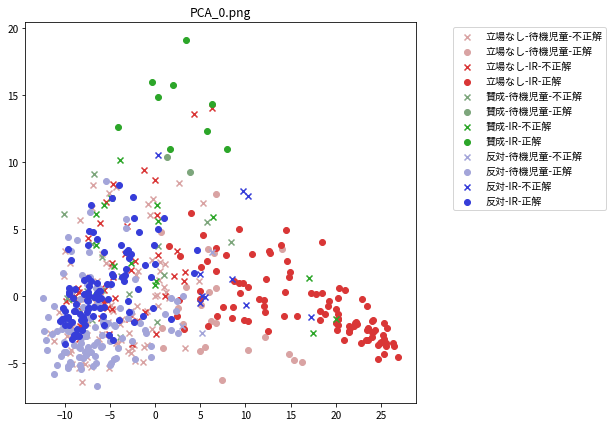

------------- stc vec -------------


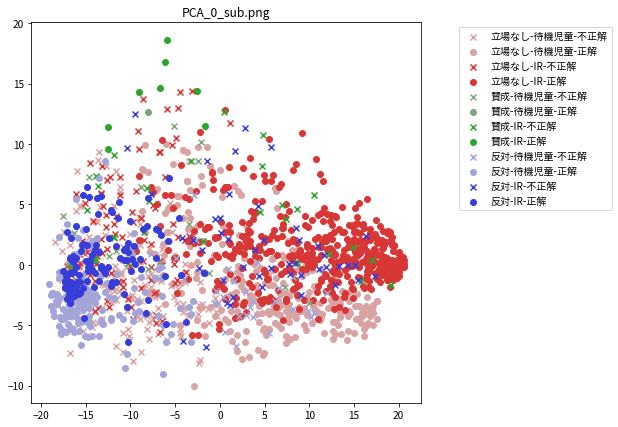

In [15]:
import copy 
from matplotlib import colors

"""
主成分分析
"""

# %matplotlib notebook
# import  IPython

def mk_markerSetting_dict(labels, topics):
    color_list_base = [[0, 0.25, 0.85], [0.33, 0.25, 0.65], [0.66, 0.25, 0.85]]
    
    marker_dict = {}
    for idx_l, label in enumerate(labels):
        for idx_t, topic in enumerate(topics):
            color = copy.copy(color_list_base[idx_l])
            color[1] += 0.5 * idx_t
            if color[1] < 0:
                raise Exception("HSVがマイナス ({})".format(color))
            marker_dict[str((idx_l, idx_t, 0))] = {"c": colors.hsv_to_rgb(color), "m": "x", "l": "{}-{}-{}".format(label, topic, "不正解")}
            marker_dict[str((idx_l, idx_t, 1))] = {"c": colors.hsv_to_rgb(color), "m": "o", "l": "{}-{}-{}".format(label, topic, "正解")}
    return marker_dict

def draw_PCA(vec_list, categorys, markerSetting_dict, path_fig):
    reduced = PCA(n_components=2).fit_transform(vec_list)
    X = reduced[:, 0]
    Y = reduced[:, 1]

    plt.figure(figsize=(7, 7))
    for k, v in markerSetting_dict.items():
        data = [(x, y) for x, y, c in myzip(X, Y, categorys) if c == k]
        if not data:
            continue
        X_, Y_ = list(myzip(*data))
        plt.scatter(X_, Y_, label=v["l"], color=v["c"], marker=v["m"])
    plt.legend(bbox_to_anchor=(1.5, 1), loc="upper right")
    plt.title(path_fig.split("/")[-1])
    plt.savefig(path_fig, bbox_inches='tight')
    plt.show()
    return reduced
            
markerSetting_dict = mk_markerSetting_dict(labelStr_list, {t: i for t, i in topic_dict.items() if t in target_topic_list})
    
if not flag_use_unknown:
    print("attr: {}".format(main_attr))
    y_true_dict, y_pred_dict, y_true_dict_sub, y_pred_dict_sub = aggregater_dict[main_attr].return_IDlabel_dict()
    if len(ID_vec_dict_sub) > 0:
        print("------------- doc vec -------------")
        
    IDs = [k for k, d in ID_vec_dict.items() if 0 in d]
    vec_list = [ID_vec_dict[ID][0] for ID in IDs]
    categorys = [str((y_true_dict[ID], ID_topic_dict[ID], int(y_true_dict[ID] is y_pred_dict[ID]))) for ID in IDs]
    path_fig = "{}/PCA_{}.png".format(path_dir_graph_vec, index_model)
    pca_ret = draw_PCA(vec_list, categorys, markerSetting_dict, path_fig)
    
    if len(ID_vec_dict_sub) > 0:
        print("------------- stc vec -------------")
        vec_list_sub = list(itertools.chain.from_iterable([[d[0] for d in ID_vec_dict_sub[ID]] for ID in IDs]))
        categorys_sub = []
        for ID in IDs:
            for t, p in myzip(y_true_dict_sub[ID].values(), y_pred_dict_sub[ID].values()):
                categorys_sub.append(str((t, ID_topic_dict[ID], int(t is p))))
        path_fig = "{}/PCA_{}_sub.png".format(path_dir_graph_vec, index_model)
        pca_ret_sub = draw_PCA(vec_list_sub, categorys_sub, markerSetting_dict, path_fig)

else:
    print("skip")

attr: 立場
------------- doc vec -------------


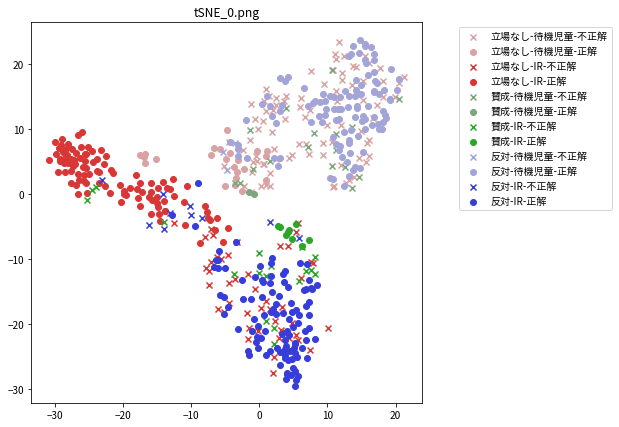

------------- stc vec -------------


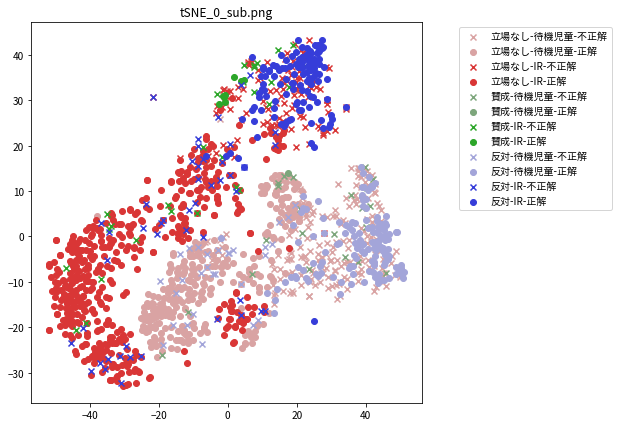

In [16]:
"""
T-SNE
"""

def draw_TSNE(vec_list, categorys, markerSetting_dict, path_fig):
    reduced = TSNE(n_components=2, random_state=1).fit_transform(vec_list)
    X = reduced[:, 0]
    Y = reduced[:, 1]

    plt.figure(figsize=(7, 7))
    for k, v in markerSetting_dict.items():
        data = [(x, y) for x, y, c in myzip(X, Y, categorys) if c == k]
        if not data:
            continue
        X_, Y_ = list(myzip(*data))
        plt.scatter(X_, Y_, label=v["l"], color=v["c"], marker=v["m"])
    plt.legend(bbox_to_anchor=(1.5, 1), loc="upper right")
    plt.title(path_fig.split("/")[-1])
    plt.savefig(path_fig, bbox_inches='tight')
    plt.show()
    return reduced

if not flag_use_unknown:
    print("attr: {}".format(main_attr))
    y_true_dict, y_pred_dict, y_true_dict_sub, y_pred_dict_sub = aggregater_dict[main_attr].return_IDlabel_dict()
    if len(ID_vec_dict_sub) > 0:
        print("------------- doc vec -------------")
        
    IDs = [k for k, d in ID_vec_dict.items() if 0 in d]
    vec_list = [ID_vec_dict[ID][0] for ID in IDs]
    categorys = [str((y_true_dict[ID], ID_topic_dict[ID], int(y_true_dict[ID] is y_pred_dict[ID]))) for ID in IDs]
    path_fig = "{}/tSNE_{}.png".format(path_dir_graph_vec, index_model)
    tsne_ret = draw_TSNE(vec_list, categorys, markerSetting_dict, path_fig)
    
    if len(ID_vec_dict_sub) > 0:
        print("------------- stc vec -------------")
        vec_list_sub = list(itertools.chain.from_iterable([[d[0] for d in ID_vec_dict_sub[ID]] for ID in IDs]))
        categorys_sub = []
        for ID in IDs:
            for t, p in myzip(y_true_dict_sub[ID].values(), y_pred_dict_sub[ID].values()):
                categorys_sub.append(str((t, ID_topic_dict[ID], int(t is p))))
        path_fig = "{}/tSNE_{}_sub.png".format(path_dir_graph_vec, index_model)
        tsne_ret_sub = draw_TSNE(vec_list_sub, categorys_sub, markerSetting_dict, path_fig)

else:
    print("skip")

In [17]:
"""
指定範囲のプロットのIDを調べる
"""

target_point = (10, 10)
range_point = 4
target_category = str((2, 1, 0)) # (属性ラベル，トピック，正誤)の順

#########################################

print(markerSetting_dict[target_category]["l"])
print("-" * 100)

x_l, x_r = target_point[0] - range_point, target_point[0] + range_point
y_l, y_r = target_point[1] - range_point, target_point[1] + range_point

ID_list_search_hit = []
for ID, xy, c in myzip(IDs, tsne_ret, categorys):
    x, y = xy
    if (x_l <= x <= x_r) and (y_l <= y <= y_r) and c == target_category:
        print(ID, xy)
        ID_list_search_hit.append(ID)

反対-IR-不正解
----------------------------------------------------------------------------------------------------


In [18]:
print("hoge")

hoge


In [19]:
# 結果をHTMLに保存
if flag_save_html:
    print("save html")

    name_html = "BERT_training_{}".format(index_model)
    os.system("jupyter nbconvert --to html --output html/{} training_BERT_ML.ipynb".format(name_html))

    print("done => {}".format(name_html))
else:
    print("skip")

skip


In [20]:
sys.exit()

SystemExit: 

In [ ]:
"""
IDを指定して予測結果，アテンションを見る
"""

ID_list = ["725371-1"]

#################################################

for ID in ID_list:#ID_list_search_hit:
    pred_labelStr = labelStr_list[y_pred_dict[ID]]
    true_labelStr = labelStr_list[y_true_dict[ID]]

    print("ID: {}".format(ID))

    # 文書の表示
    if flag_visualize_attention:
        # Attention可視化
        if "target_attn" in mode_target_use and not(flag_two_level):
            print("target:")
            for i in range(num_TA):
                if flag_multi_TA:
                    print("   [{}]".format(labelStr_list[i]))
                display(HTML(ID_attText_dict_target[ID][i]))
            print()
        if not flag_two_level:
            print("text:")
            display(HTML(ID_attText_dict[ID]))

    else:
        if not(flag_two_level):
            # アテンション可視化なし．普通の表示
            print("text:", text)

    if flag_w_stc:
        if flag_multi_TA:
            print("stc weight:")

            for i in range(num_TA):
                if flag_multi_TA:
                    print("   {}: {}".format(target_attr_list[i], weights_dict_stc[ID][i]))
                else:
                    print(weights_dict_stc[ID][i])
        else:
            print("stc weight: {}".format(weights_dict_stc[ID]))

    judge = {True: "正解", False: "不正解"}[pred_labelStr == true_labelStr]

    # 文の表示
    if flag_two_level:
        print("doc: {} ({}), ".format(pred_labelStr, judge), end="")
        for a in target_attr_list[1:]:
            p, t = aggregater_dict[a].y_pred_dict[ID], aggregater_dict[a].y_true_dict[ID]
            print(labelStr_dict[a][p], "(正解)" if p == t else "(不正解)", end=", ")
        print()
        print("-" * 30)
        
        judge_list = [1 if x == y else 0 for x, y in myzip(y_true_dict_sub[ID].values(), y_pred_dict_sub[ID].values())]
        for index_stc, (html, p, j) in enumerate(myzip(ID_attText_dict_sub[ID], y_pred_dict_sub[ID].values(), judge_list)):
            print("{}文目: {} ({}), ".format(index_stc + 1, labelStr_list[p], ("不正解", "正解")[j]), end="")
            for a in target_attr_list[1:]:
                p, t = list(aggregater_dict[a].y_pred_dict_sub[ID].values())[index_stc], list(aggregater_dict[a].y_true_dict_sub[ID].values())[index_stc]
                print(labelStr_dict[a][p], "(正解)" if p == t else "(不正解)", end=", ")
            print()
            
            if ID in ID_attText_dict_target_sub:
                print("target:")
                for i in range(num_TA):
                    if flag_multi_TA:
                        print("   [{}]".format(target_attr_list[i]))
                    display(HTML(ID_attText_dict_target_sub[ID][i][index_stc]))
                print()

            print("input:")
            display(HTML(html))
            print("-----")
    else:
        print("prediction: {} ({}), ".format(pred_labelStr, judge), end="")
        for a in target_attr_list[1:]:
            p, t = aggregater_dict[a].y_pred_dict[ID], aggregater_dict[a].y_true_dict[ID]
            print(labelStr_dict[a][p], "(正解)" if p == t else "(不正解)", end=", ")
        print("\n")
    print("=" * 100)